# Evaluating How Liberal vs. Conservative Opinion News Shows Influenced the Narrative about the COVID-19 Pandemic

**Group Members: Jennifer Andre, Tobi Jegede, Callie Lambert, & Lori Zakalik**

**Date**: May 2, 2022

**Disclaimer:** The runtime for our notebook is approximately 1 hour. In order to run our team's notebook, please make sure you have the following python libraries and packages installed on your device:
* glob
* os
* matplotlib.pyplot
* numpy
* string
* regex
* sklearn.feature_extraction
* operator
* collections
* spacy
* sklearn.decomposition
* wordcloud
* ntlk.sentiment
    *  Note: If you run into issues after downloading the above package (ntlk.sentiment), please use the code chunk below: 
    
        ```python
        import nltk 
        import ssl
        try: 
            _create_unverified_https_context = ssl._create_unverified_context
        except AttributeError:
            pass
        else:
            ssl._create_default_https_context = _create_unverified_https_context 
            
        nltk.download('vader_lexicon')
        ```

This notebook does not contain all of the analysis conducted. We've summarized where we conducted additional analysis and relevant results where applicable. The full analysis code files  can be found in the code folder on our project's GitHub page, located here: https://github.com/tobijegede/opinion-news-nlp. There are three analysis files: one for each of the three (liberal, conservative, CDC/neutral) corpora. 

# Table of Contents
1. [Background](#background)
    1. [Explanation of the Data](#data)
2. [Setup & Data Pre-Processing](#setup)
    1. [Load Data](#load)
    2. [Define COVID Terms](#terms)
    3. [Update Stop Words](#stop)
    4. [Read in, Clean, & Store Cleaned Transcripts](#read)
    5. [Store Transcript Lengths](#len)
    6. [Store Transcripts by Year](#year)
3. [Analysis #1: Word Frequency Analysis](#a1)
    1. [Liberal - Full Transcript Set](#a1liberalfull)
    2. [Conservative - Full Transcript Set](#a1conservativefull)
    3. [CDC - Full Transcript Set](#a1cdcfull)
    4. [Liberal - Restricted Transcript Set](#a1liberalre)
    5. [Conservative - Restricted Transcript Set](#a1conservativere)
    6. [CDC - Restricted Transcript Set](#a1cdcre)
    7. [Year-Over-Year Analysis](#a1yearoveryear)
4. [Analysis #2: Co-Occurrence Analysis](#a2)
    1. [Liberal - Transcript Co-Occurrence](#a2liberaltrans)
    2. [Conservative - Transcript Co-Occurrence](#a2conservativetrans)
    3. [CDC - Transcript Co-Occurence](#a2cdctrans)
    4. [A Note on Sentence Co-Occurrence](#a2sents)
5. [Analysis #3: Topic Modeling](#a3)
    1. [Liberal - Full Transcript Topic Modeling](#a3liberaltrans)
    2. [Conservative - Full Transcript Topic Modeling](#a3conservativetrans)
    3. [CDC - Full Transcript Topic Modeling](#a3cdctrans)
    4. [Liberal - Restricted Transcript Topic Modeling](#a3liberaltransre)
    5. [Conservative - Restricted Transcript Topic Modeling](#a3conservativetransre)
    6. [CDC - Restricted Transcript Topic Modeling](#a3cdctransre)
6. [Analysis #4: Sentiment Analysis](#a4)
    1. [Step 1: Subset the List of Sentences To Just Those That Include COVID Terms](#a41) 
    2. [Step 2: Apply the Sentiment Analyzer](#a42)
    3. [Step 3: Plot The Distribution of Sentence Sentiments](#a43)
    4. [Step 4: List the Top 10 "Positive" and "Negative" Sentences](#a44)
7. [Policy Implications](#policy)
8. [Future Work & Analysis Limitations](#future)

# Background <a name="background"></a>

## Explanation of the Data <a name="data"></a>

As described in our Final Project Proposal, we aim analyze how the different **opinion** news arms of popular cable news channels talk about the COVID-19 pandemic. 

Using some research from the Pew Research Center, we found that CNN and MSNBC were the most popular news channels watched by individuals who consistently voted for liberal political candidates, while Fox News was the most watched cable news channel for individuals who consistently voted for conservaive political candidates. 

We then found additional articles that provided information on the most watched tv shows on CNN, MSNBC, and Fox News. We discovered that *Anderson Cooper 360* was the most watched show on CNN, *The Rachel Maddow Show* was the most watched show on MSNBC, and *Tucker Carlson Tonight* and *The Five* were the most watched shows on Fox News. 

We then used webscraping techniques to pull the text files for the transcripts for each of the shows mentioned above from March 2020 to March 2022. The code to run this webscraping can be found in the code folder on our project's GitHub page, located here: https://github.com/tobijegede/opinion-news-nlp.

# Setup & Data Pre-Processing <a name="setup"></a>

In [136]:
#import packages & libraries
import glob 
import os
import matplotlib.pyplot as plt
import numpy as np
import string
#import regex as re
from sklearn.feature_extraction import text
from sklearn.feature_extraction.text import CountVectorizer
from operator import itemgetter
from collections import Counter
import spacy
from sklearn.decomposition import LatentDirichletAllocation
from wordcloud import WordCloud
from nltk.sentiment import SentimentIntensityAnalyzer
from matplotlib.ticker import PercentFormatter
import re

## Load Data <a name="load"></a>

**Disclaimer:** You may need to adjust the code chunk below to properly load in the data. Our current file structure is:
- Code Repository Folder (opinion-news-nlp)
    - data
        - 01-raw
            - name of opinion news show
                - a list of text files

In [137]:
#get the correct starting file path
#repo_path = os.path.dirname(os.getcwd()) 

#read in the liberal corpus
rm_paths = glob.glob("../data/01-raw/rachel_maddow/*.txt") #the paths for the rachel maddow transcript files
ac_paths = glob.glob("../data/01-raw/anderson_cooper/*.txt") #the paths for the anderson cooper transcript files
all_liberal_files = rm_paths + ac_paths # all liberal transcripts

#read in the conservative corpus 
tc_paths = glob.glob("../data/01-raw/tucker_carlson/*.txt") #the paths for the tucker carlson transcript files
tf_paths = glob.glob('../data/01-raw/the_five/*.txt') #the paths for the five transcript files
all_conservative_files = tc_paths + tf_paths #all conservative transcripts

#read in the CDC transcripts
cdc_paths = glob.glob("../data/01-raw/cdc_press_releases/*.txt") #the paths for cdc transcript files

The basic summary statistics for all of the data that we used in our analysis is as follows:
1. Conservative Corpus, N = 458
    - Tucker Carlson, 208
    - The Five, 250
2. Liberal Corpus, N = 1,008
    - Anderson Cooper, 530
    - Rachel Maddow, 478
3. CDC, N = 47


It is important to note that there are fewer transcripts in the conservative corpus than in the liberal corpus. Fox News does not have transcripts available for every show (e.g., Tucker Carlson airs every weeknight, but there are only transcripts available for 1-2 shows per week). AC360 often runs two hour-long shows (i.e., two transcripts) on a given night, contributing to the large number of liberal transcripts. Still, the conservative corpus provides a large amount of unstructured data to compare against the liberal corpus. The average transcript length in the conservative corpus is very similar to the average transcript length in the liberal corpus (see [Store Transcript Lengths](#len)). Future analyses might consider resampling techniques to balance out the data sources.

## Define COVID Terms <a name="terms"></a>

In the below cells, we created lists of words to use to help with co-occurrence analysis later on in our notebook. We specifically wanted to catalog most of the ways that COVID, mask, and vaccine words could potentially show up in the transcripts in the dataset.

In [138]:
# covid terms
covid_terms = ['coronavirus', 'covid', 'covid-19', 'covid-', 
               'covid19', 'virus', 'sars', 'sars-', 'sars-cov-2', 'sarscov2']

In [139]:
# vaccine terms
vaccine_terms = ['vaccine', 'vaccination', 'vaccinated', 'mrna', 'booster', 'vax', 'vaxx', 
                 'vaxxed', 'pfizer', 'moderna', 'johnson', 'j&j', 'jj', 'biontech', 'pfizerbiontech', 
                 'astra', 'zeneca', 'astrazeneca', 'oxford', 'astrazenecaoxford']

In [140]:
# mask terms
mask_terms = ['mask', 'masking', 'n95', 'kn95', 'n', 'kn']

In [141]:
# other COVID-related terms
other_terms = ['china', 'wuhan', 'mandate', 'pandemic', 'epidemic', 'virus',
               'distancing', 'spread', 'immunity', 'incubation', 'quarantine']

all_covid_terms = covid_terms + other_terms

## Update Stop Words <a name="stop"></a>

In the section of code below, we add specific stop words for the conservative, liberal, and CDC news sources in order to remove named entities, like the names of the talk show hosts and the name of the CDC, from the list of relevant words to count.

In [142]:
# add host names, important figures for conservative news corpus
add_stop_words_conservative = ['tucker', 'carlson', 'fox', 'news', 'five', 
                               'greg', 'gutfeld', 'dana', 'perino', 'jesse', 'watters',
                               'jeanine', 'pirro', 'geraldo', 'rivera', 'jessica', 'tarlov',
                               'harold', 'ford', 'jr', 'ok', 'williams',  'pavlich',
                               'anthony', 'tony', 'fauci', 'faucis', 'dr',
                               'mcdowell', 'juan', 'thanks', 'crosstalk', 'unidentified',
                               'video', 'clip', 'voiceover', 'videotape',
                               'brian', 'kilmeade', 'dan', 'bongino',
                               'chris', 'andrew', 'cuomo', 'emily', 'compagno',
                               'bernie', 'sanders', 'tonight', 'joins', 'quote',
                               'joe', 'biden', 'kamala', 'harris']

# add host names, important figures for the liberal news corpus
add_stop_words_liberal = ['anderson', 'cooper', 'rachel', 'maddow',
                          'chris', 'hayes', 'ari', 'berman', 'michael', 'osterholm',
                          'cnn', 'msnbc', 'cnns', 'msnbcs',
                          'vivek', 'murthy', 'rochelle', 'walensky', 
                          'jerome', 'adams', 'alex', 'azar',
                          'anthony', 'tony', 'fauci', 'faucis', 'dr',
                          'andrew', 'cuomo', 'erin', 'david',
                          'leana', 'wen', 'deborah', 'birx',
                          'robert', 'redfield', 'gavin', 'newsom',
                          'ashish', 'jha', 'tom', 'frieden',
                          'video', 'clip', 'voiceover', 'videotape',
                          'tonight', 'joins', 'quote',
                          'joe', 'biden', 'kamala', 'harris',
                          'bill', 'barr', 'roger', 'stone', 'michael', 'flynn']

# add common words for the cdc news corpus
add_stop_words_cdc = ['question', 'cdc', 'cdcs', "anthony", "fauci", "dr", 
                      "thanks", "thank", "people", "rochelle", "walensky"]

In [143]:
#create the full list of stop words for each of the corpuses
full_stop_words_conservative = text.ENGLISH_STOP_WORDS.union(add_stop_words_conservative)
full_stop_words_liberal = text.ENGLISH_STOP_WORDS.union(add_stop_words_liberal)
full_stop_words_cdc = text.ENGLISH_STOP_WORDS.union(add_stop_words_cdc)

## Read in, Clean, & Store Cleaned Transcripts <a name="read"></a>

In this section of code, we create objects to store cleaned transcripts, sentences, and relevant counts for each corpus. For each corpus, we plot the distribution of COVID mentions in the transcripts.

In [144]:
#---------- IMPORTING & CLEANING THE LIBERAL CORPUS
text_transcripts_liberal = [] # container for transcript text
text_sentences_liberal = [] # container for sentence text: NOTE: WILL USE TEXT_SENTENCES FOR THE SENTIMENT ANALYSIS
covid_counts_transcripts_liberal = [] # container for transcript covid mention counts
covid_counts_sentences_liberal  = [] # container for sentence covid mention counts

# read in each transcript, do text cleaning, add text and counts to containers
# split sentences on periods, do text cleaning, add text and counts to containers
# text cleaning is done separately for transcripts and sentences to help split sentences better

#### transcripts as documents
for transcript in all_liberal_files:
    
    # create transcript covid counter
    cov_trans_counter = 0
    
    # read text
    text = open(transcript, encoding = 'utf-8').read().lower()
    
    ### string cleaning
    # line below replaces periods with spaces because spaces after periods are often missing, then strips extra spaces
    corpus_text = text.replace('\xa0', '').replace('.', ' ').replace('  ', ' ')
    # remove all punctuation
    for c in string.punctuation:
        corpus_text = corpus_text.replace(c, "")
    # remove numbers
    corpus_text = re.sub('\d+', '', corpus_text)
    # remove whitespaces
    corpus_text = " ".join(corpus_text.split())
    
    # add cleaned text to container
    text_transcripts_liberal.append(corpus_text)
    
    # add to counter if word in text is in covid terms, add count to container
    for word in corpus_text.split(' '):
        if word in covid_terms:
            cov_trans_counter += 1
    covid_counts_transcripts_liberal.append(cov_trans_counter)
    
    
    #### sentences as documents
    for sentence in text.split('.'): # note that splitting on periods is not perfect for identifying sentences
        
        # create sentence covid counter
        cov_sen_counter = 0
        
        ### string cleaning
        corpus_sen = sentence.replace('\xa0', '')
        # remove all punctuation    
        for c in string.punctuation:
            corpus_sen = corpus_sen.replace(c, "")
        # remove numbers            
        corpus_sen = re.sub('\d+', '', corpus_sen)
        # remove whitespaces
        corpus_sen = " ".join(corpus_sen.split())
        
        # add cleaned sentence to container
        text_sentences_liberal.append(corpus_sen)
        
        # add to counter if word in sentence is in covid terms, add count to container
        for word in corpus_sen.split(' '):
            if word in covid_terms:
                cov_sen_counter += 1
        covid_counts_sentences_liberal.append(cov_sen_counter)  

In [145]:
# display counts for the liberal corpus
print("Our liberal news corpus consists of {:,} total transcripts, sourced from Anderson Cooper 360 and the Rachel Maddow Show.".format(len(text_transcripts_liberal)))

print("There are {:,} total sentences in the liberal corpus.".format(len(text_sentences_liberal)))

print("There are {:,} liberal transcripts that mention COVID at least once.".format(len(text_transcripts_liberal) - covid_counts_transcripts_liberal.count(0)))

Our liberal news corpus consists of 1,008 total transcripts, sourced from Anderson Cooper 360 and the Rachel Maddow Show.
There are 459,365 total sentences in the liberal corpus.
There are 876 liberal transcripts that mention COVID at least once.


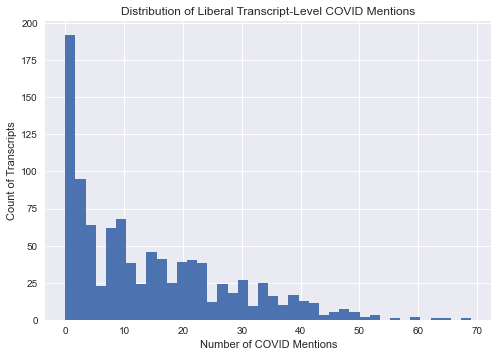

In [146]:
# Distribution of COVID mentions - transcripts
plt.style.use('seaborn')  

fig = plt.figure()
plt.hist(covid_counts_transcripts_liberal, bins = 40)
plt.xlabel('Number of COVID Mentions')
plt.ylabel('Count of Transcripts')
plt.title('Distribution of Liberal Transcript-Level COVID Mentions')

plt.show()

#fig.savefig(repo_path +'/images/liberal-distribution-covid-mentions.png')

In [147]:
#---------- IMPORTING & CLEANING THE CONSERVATIVE CORPUS
text_transcripts_conservative = [] # container for transcript text
text_sentences_conservative = [] # container for sentence text
covid_counts_transcripts_conservative = [] # container for transcript covid mention counts
covid_counts_sentences_conservative = [] # container for sentence covid mention counts

# read in each transcript, do text cleaning, add text and counts to containers
# split sentences on periods, do text cleaning, add text and counts to containers
# text cleaning is done separately for transcripts and sentences to help split sentences better

#### transcripts as documents
for transcript in all_conservative_files:
    
    # create transcript covid counter
    cov_trans_counter = 0
    
    # read text
    text = open(transcript, encoding = 'utf-8', errors = 'ignore').read().lower()  # Added ignore for a few characters that were not ASCII
    
    ### string cleaning
    # line below replaces periods with spaces because spaces after periods are often missing, then strips extra spaces
    corpus_text = text.replace('\xa0', '').replace('.', ' ').replace('  ', ' ')
    # remove all punctuation
    for c in string.punctuation:
        corpus_text = corpus_text.replace(c, "")
    # remove numbers
    corpus_text = re.sub('\d+', '', corpus_text)
    # remove whitespaces
    corpus_text = " ".join(corpus_text.split())
    
    # add cleaned text to container
    text_transcripts_conservative.append(corpus_text)
    
    # add to counter if word in text is in covid terms, add count to container
    for word in corpus_text.split(' '):
        if word in covid_terms:
            cov_trans_counter += 1
    covid_counts_transcripts_conservative.append(cov_trans_counter)
    
    
    #### sentences as documents
    for sentence in text.split('.'): # note that splitting on periods is not perfect for identifying sentences
        
        # create sentence covid counter
        cov_sen_counter = 0
        
        ### string cleaning
        corpus_sen = sentence.replace('\xa0', '')
        # remove all punctuation    
        for c in string.punctuation:
            corpus_sen = corpus_sen.replace(c, "")
        # remove numbers            
        corpus_sen = re.sub('\d+', '', corpus_sen)
        # remove whitespaces
        corpus_sen = " ".join(corpus_sen.split())
        
        # add cleaned sentence to container
        text_sentences_conservative.append(corpus_sen)
        
        # add to counter if word in sentence is in covid terms, add count to container
        for word in corpus_sen.split(' '):
            if word in covid_terms:
                cov_sen_counter += 1
        covid_counts_sentences_conservative.append(cov_sen_counter) 

In [148]:
# display counts for the conservative corpus
print("Our conservative news corpus consists of {:,} total transcripts, sourced from Tucker Carlson Tonight and The Five.".format(len(text_transcripts_conservative)))

print("There are {:,} total sentences in the conservative corpus.".format(len(text_sentences_conservative)))

print("There are {:,} conservative transcripts that mention COVID at least once.".format(len(text_transcripts_conservative) - covid_counts_transcripts_conservative.count(0)))

Our conservative news corpus consists of 458 total transcripts, sourced from Tucker Carlson Tonight and The Five.
There are 254,010 total sentences in the conservative corpus.
There are 434 conservative transcripts that mention COVID at least once.


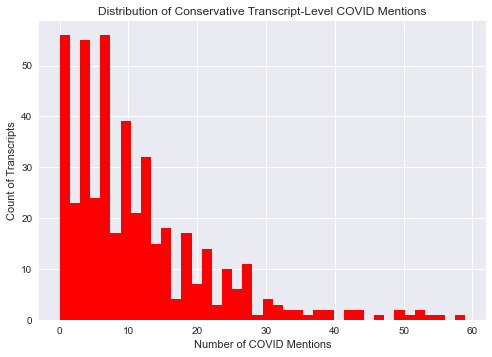

In [149]:
# Distribution of COVID mentions - transcripts
plt.style.use('seaborn')  

fig = plt.figure()
plt.hist(covid_counts_transcripts_conservative, bins = 40, color = 'red')
plt.xlabel('Number of COVID Mentions')
plt.ylabel('Count of Transcripts')
plt.title('Distribution of Conservative Transcript-Level COVID Mentions')

plt.show()

#fig.savefig(repo_path +'/images/conservative-distribution-covid-mentions.png')

In [150]:
#---------- IMPORTING & CLEANING THE CDC CORPUS
text_transcripts_cdc = [] # container for transcript text
text_sentences_cdc = [] # container for sentence text
covid_counts_transcripts_cdc = [] # container for transcript covid mention counts
covid_counts_sentences_cdc = []
# read in each transcript, do text cleaning, add text and counts to containers
# split sentences on periods, do text cleaning, add text and counts to containers
# text cleaning is done separately for transcripts and sentences to help split sentences better

#### transcripts as documents
for transcript in cdc_paths:
    
    # create transcript covid counter
    cov_trans_counter = 0
    
    # read text
    text = open(transcript, encoding = 'utf-8').read().lower()
    
    ### string cleaning
    # line below replaces periods with spaces because spaces after periods are often missing, then strips extra spaces
    corpus_text = text.replace('\xa0', '').replace('.', ' ').replace('  ', ' ')
    # remove all punctuation
    for c in string.punctuation:
        corpus_text = corpus_text.replace(c, "")
    # remove numbers
    corpus_text = re.sub('\d+', '', corpus_text)
    # remove special apostrophe
    corpus_text = corpus_text.replace("’", "")
    # remove whitespaces
    corpus_text = " ".join(corpus_text.split())
    
    # add cleaned text to container
    text_transcripts_cdc.append(corpus_text)
    
    # add to counter if word in text is in covid terms, add count to container
    for word in corpus_text.split(' '):
        if word in covid_terms:
            cov_trans_counter += 1
    covid_counts_transcripts_cdc.append(cov_trans_counter)

     #### sentences as documents
    for sentence in text.split('.'): # note that splitting on periods is not perfect for identifying sentences
        
        # create sentence covid counter
        cov_sen_counter = 0
        
        ### string cleaning
        corpus_sen = sentence.replace('\xa0', '')
        # remove all punctuation    
        for c in string.punctuation:
            corpus_sen = corpus_sen.replace(c, "")
        # remove numbers            
        corpus_sen = re.sub('\d+', '', corpus_sen)
        # remove special apostrophe
        corpus_sen = corpus_sen.replace("’", "")
        # remove whitespaces
        corpus_sen = " ".join(corpus_sen.split())
        
        # add cleaned sentence to container
        text_sentences_cdc.append(corpus_sen)
        
        # add to counter if word in sentence is in covid terms, add count to container
        for word in corpus_sen.split(' '):
            if word in covid_terms:
                cov_sen_counter += 1
        covid_counts_sentences_cdc.append(cov_sen_counter) 

In [151]:
# Display counts for the CDC corpus
print("Our CDC 'neutral' corpus consists of {:,} total transcripts.".format(len(text_transcripts_cdc)))

print("There are {:,} 'neutral' transcripts that mention COVID at least once.".format(len(text_transcripts_cdc) - covid_counts_transcripts_cdc.count(0)))

Our CDC 'neutral' corpus consists of 47 total transcripts.
There are 46 'neutral' transcripts that mention COVID at least once.


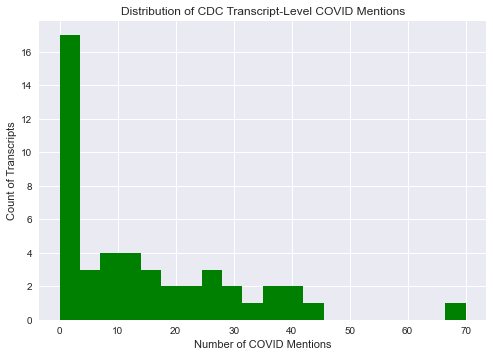

In [152]:
# Distribution of COVID mentions - transcripts
plt.style.use('seaborn')  

fig = plt.figure() 
plt.hist(covid_counts_transcripts_cdc, bins = 20, color = 'green')
plt.xlabel('Number of COVID Mentions')
plt.ylabel('Count of Transcripts')
plt.title('Distribution of CDC Transcript-Level COVID Mentions')

plt.show()

#fig.savefig(repo_path + '/images/cdc-distribution-covid-mentions.png')

## Store Transcript Lengths <a name="len"></a>

In [153]:
# count number of words in each liberal transcript
liberal_word_counter = []
for transcript in text_transcripts_liberal:
    counter = 0
    for word in transcript.split(' '):
        counter += 1
    liberal_word_counter.append(counter)

# count number of words in each conservative transcript
conservative_word_counter = []
for transcript in text_transcripts_conservative:
    counter = 0
    for word in transcript.split(' '):
        counter += 1
    conservative_word_counter.append(counter)
    
# count number of words in each cdc transcript
cdc_word_counter = []
for transcript in text_transcripts_cdc:
    counter = 0
    for word in transcript.split(' '):
        counter += 1
    cdc_word_counter.append(counter)

In [154]:
# Print average transcript lengths
print("The average liberal transcript length is {:,} words.".format(round(sum(liberal_word_counter) / len(liberal_word_counter))))

print("The average conservative transcript length is {:,} words.".format(round(sum(conservative_word_counter) / len(conservative_word_counter))))

print("The average CDC transcript length is {:,} words.".format(round(sum(cdc_word_counter) / len(cdc_word_counter))))

The average liberal transcript length is 7,907 words.
The average conservative transcript length is 7,626 words.
The average CDC transcript length is 2,161 words.


## Store Transcripts by Year <a name="year"></a>

In [155]:
#---------- YEAR OVER YEAR ANALYSIS FOR THE LIBERAL CORPUS
text_transcripts_2020_liberal = [] # container for transcript text
text_transcripts_2021_liberal = [] # container for transcript text
text_transcripts_2022_liberal = [] # container for transcript text

covid_counts_transcripts_2020_liberal = [] # container for transcript covid mention counts
covid_counts_transcripts_2021_liberal = [] # container for transcript covid mention counts
covid_counts_transcripts_2022_liberal = [] # container for transcript covid mention counts


# read in each transcript, do text cleaning, add text and counts to containers
# split sentences on periods, do text cleaning, add text and counts to containers
# text cleaning is done separately for transcripts and sentences to help split sentences better

#### transcripts as documents
for transcript in all_liberal_files:

    # create transcript covid counter
    cov_trans_counter = 0
    
    # read text
    text = open(transcript, encoding = 'utf-8').read().lower()
    
    ## string cleaning
    # line below replaces periods with spaces because spaces after periods are often missing, then strips extra spaces
    corpus_text = text.replace('\xa0', '').replace('.', ' ').replace('  ', ' ')
    # remove all punctuation
    for c in string.punctuation:
        corpus_text = corpus_text.replace(c, "")
    # remove numbers
    corpus_text = re.sub('\d+', '', corpus_text)
    # remove whitespaces
    corpus_text = " ".join(corpus_text.split())

     # add to counter if word in text is in covid terms, add count to container
    for word in corpus_text.split(' '):
        if word in covid_terms:
            cov_trans_counter += 1
   
    if "2020" in transcript:
        # add cleaned text to container
        text_transcripts_2020_liberal.append(corpus_text)
        covid_counts_transcripts_2020_liberal.append(cov_trans_counter)
    
    elif "2021" in transcript:
        text_transcripts_2021_liberal.append(corpus_text)
        covid_counts_transcripts_2021_liberal.append(cov_trans_counter)

    else: 
        text_transcripts_2022_liberal.append(corpus_text)
        covid_counts_transcripts_2022_liberal.append(cov_trans_counter)

In [156]:
print("There are {} liberal transcripts from 2020, {} from 2021, and {} from 2022".format(len(text_transcripts_2020_liberal), len(text_transcripts_2021_liberal), len(text_transcripts_2022_liberal) ))


There are 384 liberal transcripts from 2020, 517 from 2021, and 107 from 2022


In [157]:
#---------- YEAR OVER YEAR ANALYSIS FOR THE CONSERVATIVE CORPUS
text_transcripts_2020_conservative = [] # container for transcript text
text_transcripts_2021_conservative = [] # container for transcript text
text_transcripts_2022_conservative = [] # container for transcript text

covid_counts_transcripts_2020_conservative = [] # container for transcript covid mention counts
covid_counts_transcripts_2021_conservative = [] # container for transcript covid mention counts
covid_counts_transcripts_2022_conservative = [] # container for transcript covid mention counts


# read in each transcript, do text cleaning, add text and counts to containers
# split sentences on periods, do text cleaning, add text and counts to containers
# text cleaning is done separately for transcripts and sentences to help split sentences better

#### transcripts as documents
for transcript in all_conservative_files:

    # create transcript covid counter
    cov_trans_counter = 0
    
    # read text
    text = open(transcript, encoding = 'utf-8', errors = 'ignore').read().lower()
    
    ## string cleaning
    # line below replaces periods with spaces because spaces after periods are often missing, then strips extra spaces
    corpus_text = text.replace('\xa0', '').replace('.', ' ').replace('  ', ' ')
    # remove all punctuation
    for c in string.punctuation:
        corpus_text = corpus_text.replace(c, "")
    # remove numbers
    corpus_text = re.sub('\d+', '', corpus_text)
    # remove whitespaces
    corpus_text = " ".join(corpus_text.split())

     # add to counter if word in text is in covid terms, add count to container
    for word in corpus_text.split(' '):
        if word in covid_terms:
            cov_trans_counter += 1
   
    
    if "2020" in transcript:
        # add cleaned text to container
        text_transcripts_2020_conservative.append(corpus_text)
        covid_counts_transcripts_2020_conservative.append(cov_trans_counter)
    
    elif "2021" in transcript:
        text_transcripts_2021_conservative.append(corpus_text)
        covid_counts_transcripts_2021_conservative.append(cov_trans_counter)

    else: 
        text_transcripts_2022_conservative.append(corpus_text)
        covid_counts_transcripts_2022_conservative.append(cov_trans_counter)

In [158]:
print("There are {} conservative transcripts from 2020, {} from 2021, and {} from 2022".format(len(text_transcripts_2020_conservative), len(text_transcripts_2021_conservative), len(text_transcripts_2022_conservative) ))

There are 147 conservative transcripts from 2020, 271 from 2021, and 40 from 2022


# Analysis #1: Word Frequency Analysis <a name="a1"></a>

In order to get a high level picture of the datasets that we had available, and to do a basic sense check, we first conducted word frequency analysis using sklearn's Count Vectorizer and examining top words. For the liberal and conservative corpora, we also run this analysis on "restricted" versions of each corpus, which only use those transcripts that include a COVID term at least 5 times. Finally, we run this analysis by year to examine changes over time.

In [159]:
# set up count vectorizer function
def countvec(text_list, stop_words):
    
    # step 1: set up the vectorizer
    vectorizer = CountVectorizer(min_df = 0.05, 
                                 stop_words = stop_words, 
                                 max_df = 0.8)
    
    # step 2: apply the vectorizer to the corpus of documents and store in document matrix X
    X = vectorizer.fit(text_list)
    
    # step 3: fit transform corpus of documents
    X_transformed = vectorizer.fit_transform(text_list)
    
    # step 4: extract feature names and counts, create dictionary
    array_of_words = vectorizer.get_feature_names()
    array_of_counts = X_transformed.toarray().sum(axis = 0)
    word_frequency_dictionary = dict(zip(array_of_words, array_of_counts))
    
    return(X, X_transformed, array_of_words, array_of_counts, word_frequency_dictionary)

## Liberal - Full Transcript Set <a name="a1liberalfull"></a>

In [160]:
# apply function to full transcript set
X_trans_liberal, X_transformed_trans_liberal, array_of_words_trans_liberal, array_of_counts_trans_liberal, word_frequency_dictionary_trans_liberal = countvec(text_transcripts_liberal, full_stop_words_liberal)

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [161]:
# vocabulary length
print("There are {:,} unique words in the vocabulary.".format(len(X_trans_liberal.vocabulary_)))

There are 4,787 unique words in the vocabulary.


In [162]:
#check to see if "coronavirus" is in the dictionary, print index value
vocab = X_trans_liberal.vocabulary_

vocab['coronavirus']

961

In [163]:
# set number of top words to see
num_top_words = 10

top_10_words_liberal = dict(sorted(word_frequency_dictionary_trans_liberal.items(), key = itemgetter(1), reverse = True)[:num_top_words])

print(top_10_words_liberal)

{'republicans': 6011, 'police': 5514, 'health': 5366, 'vote': 5239, 'justice': 5228, 'court': 5171, 'vaccine': 5035, 'senate': 4960, 'department': 4889, 'york': 4840}


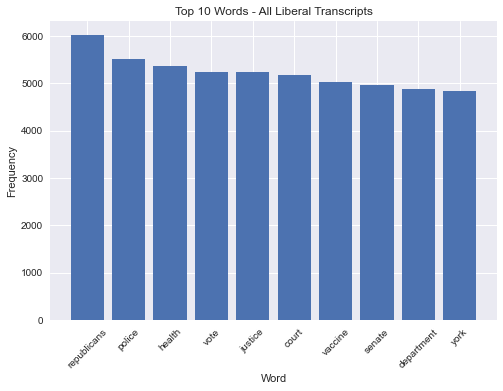

In [164]:
# plot top words
plt.style.use('seaborn')  

fig = plt.figure()

x = top_10_words_liberal.keys()
y = top_10_words_liberal.values()
plt.bar(x,y)
plt.xlabel('Word')
plt.xticks(rotation=45)
plt.ylabel('Frequency')
plt.title('Top 10 Words - All Liberal Transcripts')

plt.show()

#fig.savefig(repo_path +'/images/liberal-top-words.png')

## Conservative - Full Transcript Set <a name="a1conservativefull"></a>

In [165]:
# apply function to full transcript set
X_trans_conservative, X_transformed_trans_conservative, array_of_words_trans_conservative, array_of_counts_trans_conservative, word_frequency_dictionary_trans_conservative = countvec(text_transcripts_conservative, full_stop_words_conservative)

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [166]:
# vocabulary length
print("There are {:,} unique words in the vocabulary.".format(len(X_trans_conservative.vocabulary_)))

There are 5,014 unique words in the vocabulary.


In [167]:
#check to see if "coronavirus" is in the dictionary, print index value
vocab = X_trans_conservative.vocabulary_

vocab['coronavirus']

1001

In [168]:
# set number of top words to see
num_top_words = 10

top_10_words_conservative = dict(sorted(word_frequency_dictionary_trans_conservative.items(), key = itemgetter(1), reverse = True)[:num_top_words])

print(top_10_words_conservative)

{'police': 2669, 'administration': 1647, 'kids': 1617, 'school': 1612, 'black': 1605, 'vaccine': 1556, 'china': 1511, 'crime': 1501, 'border': 1475, 'shes': 1442}


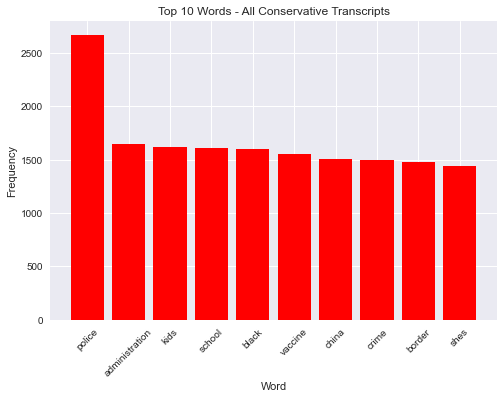

In [169]:
# plot top words
plt.style.use('seaborn')  

fig = plt.figure()

x = top_10_words_conservative.keys()
y = top_10_words_conservative.values()
plt.bar(x,y, color = 'red')
plt.xlabel('Word')
plt.xticks(rotation=45)
plt.ylabel('Frequency')
plt.title('Top 10 Words - All Conservative Transcripts')

plt.show()

#fig.savefig(repo_path +'/images/conservative-top-words.png')

## CDC - Full Transcript Set <a name="a1cdcfull"></a>

In [170]:
# apply function to full transcript set
X_trans_cdc, X_transformed_trans_cdc, array_of_words_trans_cdc, array_of_counts_trans_cdc, word_frequency_dictionary_trans_cdc = countvec(text_transcripts_cdc, full_stop_words_cdc)

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [171]:
# vocabulary length
print("There are {:,} unique words in the vocabulary.".format(len(X_trans_cdc.vocabulary_)))

There are 1,911 unique words in the vocabulary.


In [172]:
#check to see if "coronavirus" is in the dictionary, print index value
vocab = X_trans_cdc.vocabulary_

vocab['coronavirus']

359

In [173]:
# set number of top words to see
num_top_words = 10

top_10_words_cdc = dict(sorted(word_frequency_dictionary_trans_cdc.items(), key = itemgetter(1), reverse = True)[:num_top_words])

print(top_10_words_cdc)

{'health': 407, 'know': 379, 'think': 277, 'risk': 246, 'public': 230, 'cases': 226, 'data': 224, 'states': 203, 'like': 200, 'want': 200}


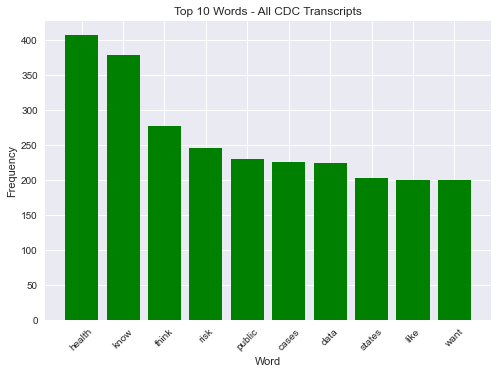

In [174]:
# plot top words
plt.style.use('seaborn')  

fig = plt.figure()

x = top_10_words_cdc.keys()
y = top_10_words_cdc.values()
plt.bar(x,y, color = 'green')
plt.xlabel('Word')
plt.xticks(rotation=45)
plt.ylabel('Frequency')
plt.title('Top 10 Words - All CDC Transcripts')

plt.show()

#fig.savefig(repo_path +'/images/cdc-top-words.png')

## Liberal - Restricted Transcript Set <a name="a1liberalre"></a>

In [175]:
# create a restricted transcript list including only transcripts that mention a COVID term 5+ times
text_transcripts_liberal_cov = [text_transcripts_liberal[i] for i in range(len(text_transcripts_liberal)) if covid_counts_transcripts_liberal[i] >= 5]

In [176]:
# apply function to full transcript set
X_trans_liberal_cov, X_transformed_trans_liberal_cov, array_of_words_trans_liberal_cov, array_of_counts_trans_liberal_cov, word_frequency_dictionary_trans_liberal_cov = countvec(text_transcripts_liberal_cov, full_stop_words_liberal)

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [177]:
# vocabulary length
print("There are {:,} unique words in the vocabulary.".format(len(X_trans_liberal_cov.vocabulary_)))

There are 4,791 unique words in the vocabulary.


In [178]:
#check to see if "coronavirus" is in the dictionary, print index value
vocab = X_trans_liberal_cov.vocabulary_

vocab['coronavirus']

967

In [179]:
# set number of top words to see
num_top_words = 10

top_10_words_liberal_cov = dict(sorted(word_frequency_dictionary_trans_liberal_cov.items(), key = itemgetter(1), reverse = True)[:num_top_words])

print(top_10_words_liberal_cov)

{'vaccine': 4668, 'republicans': 3738, 'coronavirus': 3719, 'virus': 3663, 'governor': 3464, 'vote': 3287, 'police': 3063, 'percent': 2975, 'senate': 2971, 'department': 2968}


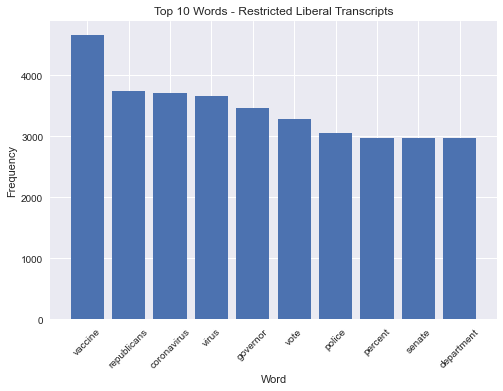

In [180]:
# plot top words
plt.style.use('seaborn')  

fig = plt.figure()

x = top_10_words_liberal_cov.keys()
y = top_10_words_liberal_cov.values()
plt.bar(x,y)
plt.xlabel('Word')
plt.xticks(rotation=45)
plt.ylabel('Frequency')
plt.title('Top 10 Words - Restricted Liberal Transcripts')

plt.show()

## Conservative - Restricted Transcript Set <a name="a1conservativere"></a>

In [181]:
# create a restricted transcript list including only transcripts that mention a COVID term 5+ times
text_transcripts_conservative_cov = [text_transcripts_conservative[i] for i in range(len(text_transcripts_conservative)) if covid_counts_transcripts_conservative[i] >= 5]

In [182]:
# apply function to full transcript set
X_trans_conservative_cov, X_transformed_trans_conservative_cov, array_of_words_trans_conservative_cov, array_of_counts_trans_conservative_cov, word_frequency_dictionary_trans_conservative_cov = countvec(text_transcripts_conservative_cov, full_stop_words_conservative)

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [183]:
# vocabulary length
print("There are {:,} unique words in the vocabulary.".format(len(X_trans_conservative_cov.vocabulary_)))

There are 4,891 unique words in the vocabulary.


In [184]:
#check to see if "coronavirus" is in the dictionary, print index value
vocab = X_trans_conservative_cov.vocabulary_

vocab['coronavirus']

971

In [185]:
# set number of top words to see
num_top_words = 10

top_10_words_conservative_cov = dict(sorted(word_frequency_dictionary_trans_conservative_cov.items(), key = itemgetter(1), reverse = True)[:num_top_words])

print(top_10_words_conservative_cov)

{'police': 1847, 'vaccine': 1383, 'coronavirus': 1365, 'china': 1309, 'virus': 1174, 'administration': 1142, 'mask': 1113, 'kids': 1102, 'school': 1086, 'black': 1071}


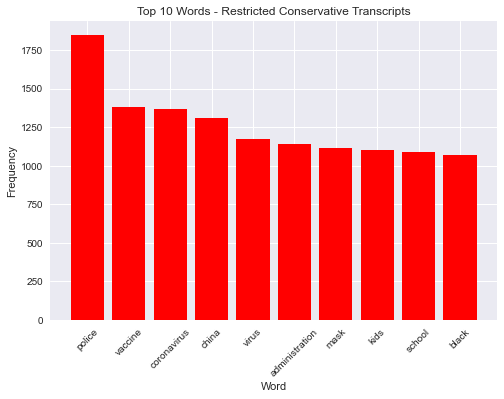

In [186]:
# plot top words
plt.style.use('seaborn')  

fig = plt.figure()

x = top_10_words_conservative_cov.keys()
y = top_10_words_conservative_cov.values()
plt.bar(x,y, color = 'red')
plt.xlabel('Word')
plt.xticks(rotation=45)
plt.ylabel('Frequency')
plt.title('Top 10 Words - Restricted Conservative Transcripts')

plt.show()

## CDC - Restricted Transcript Set <a name="a1cdcre"></a>

In [187]:
# create a restricted transcript list including only transcripts that mention a COVID term 5+ times
text_transcripts_cdc_cov = [text_transcripts_cdc[i] for i in range(len(text_transcripts_cdc)) if covid_counts_transcripts_cdc[i] >= 5]

In [188]:
# apply function to full transcript set
X_trans_cdc_cov, X_transformed_trans_cdc_cov, array_of_words_trans_cdc_cov, array_of_counts_trans_cdc_cov, word_frequency_dictionary_trans_cdc_cov = countvec(text_transcripts_cdc_cov, full_stop_words_cdc)

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [189]:
# vocabulary length
print("There are {:,} unique words in the vocabulary.".format(len(X_trans_cdc_cov.vocabulary_)))

There are 2,599 unique words in the vocabulary.


In [190]:
#check to see if "coronavirus" is in the dictionary, print index value
vocab = X_trans_cdc_cov.vocabulary_

vocab['coronavirus']

516

In [191]:
# set number of top words to see
num_top_words = 10

top_10_words_cdc_cov = dict(sorted(word_frequency_dictionary_trans_cdc_cov.items(), key = itemgetter(1), reverse = True)[:num_top_words])

print(top_10_words_cdc_cov)

{'know': 377, 'covid': 353, 'think': 277, 'just': 199, 'like': 190, 'operator': 188, 'really': 183, 'going': 173, 'open': 171, 'haynes': 167}


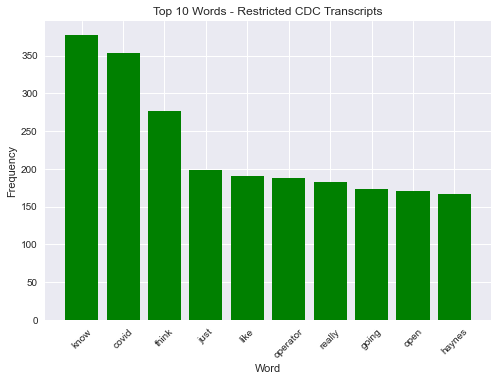

In [192]:
# plot top words
plt.style.use('seaborn')  

fig = plt.figure()

x = top_10_words_cdc_cov.keys()
y = top_10_words_cdc_cov.values()
plt.bar(x,y, color = 'green')
plt.xlabel('Word')
plt.xticks(rotation=45)
plt.ylabel('Frequency')
plt.title('Top 10 Words - Restricted CDC Transcripts')

plt.show()

## Year-Over-Year Analysis <a name="a1yearoveryear"></a>

In [193]:
#---------- YEAR OVER YEAR ANALYSIS FOR THE LIBERAL CORPUS
X_2020_liberal, X_transformed_2020_liberal, array_of_words_2020_liberal, array_of_counts_2020_liberal, word_frequency_dictionary_2020_liberal = countvec(text_transcripts_2020_liberal, full_stop_words_liberal)
X_2021_liberal, X_transformed_2021_liberal, array_of_words_2021_liberal, array_of_counts_2021_liberal, word_frequency_dictionary_2021_liberal = countvec(text_transcripts_2021_liberal, full_stop_words_liberal)
X_2022_liberal, X_transformed_2022_liberal, array_of_words_2022_liberal, array_of_counts_2022_liberal, word_frequency_dictionary_2022_liberal = countvec(text_transcripts_2022_liberal, full_stop_words_liberal)

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [194]:
print("There are {:,} unique words in the liberal vocabulary for 2020.".format(len(X_2020_liberal.vocabulary_)))
print("There are {:,} unique words in the liberal vocabulary for 2021.".format(len(X_2021_liberal.vocabulary_)))
print("There are {:,} unique words in the liberal vocabulary for 2022.".format(len(X_2022_liberal.vocabulary_)))

There are 4,660 unique words in the liberal vocabulary for 2020.
There are 4,892 unique words in the liberal vocabulary for 2021.
There are 4,896 unique words in the liberal vocabulary for 2022.


In [195]:
#check to see if "coronavirus" is in the dictionary, print index
vocab_2020_liberal = X_2020_liberal.vocabulary_
vocab_2021_liberal = X_2021_liberal.vocabulary_
vocab_2022_liberal = X_2022_liberal.vocabulary_

vocab_2021_liberal['coronavirus']

993

In [196]:
#set the number of top words to see
num_top_words = 10

top_10_words_2020_liberal = dict(sorted(word_frequency_dictionary_2020_liberal.items(), key = itemgetter(1), reverse = True)[:num_top_words])
top_10_words_2021_liberal = dict(sorted(word_frequency_dictionary_2021_liberal.items(), key = itemgetter(1), reverse = True)[:num_top_words])
top_10_words_2022_liberal = dict(sorted(word_frequency_dictionary_2022_liberal.items(), key = itemgetter(1), reverse = True)[:num_top_words])

print(top_10_words_2020_liberal)
print(top_10_words_2021_liberal)
print(top_10_words_2022_liberal)

{'election': 4108, 'testing': 2439, 'governor': 1987, 'vaccine': 1974, 'court': 1947, 'campaign': 1865, 'police': 1860, 'general': 1834, 'vote': 1827, 'hospital': 1730}
{'capitol': 3461, 'police': 3350, 'justice': 3047, 'vote': 3015, 'vaccine': 2946, 'senator': 2611, 'court': 2565, 'investigation': 2527, 'party': 2527, 'texas': 2487}
{'ukraine': 1835, 'russian': 1547, 'russia': 1266, 'january': 1112, 'putin': 993, 'committee': 757, 'ukrainian': 757, 'republican': 706, 'investigation': 700, 'court': 659}


/var/folders/l8/t9x4mbrd2qz1gg4gt4t9rttc0000gn/T/ipykernel_50262/3424777231.py:17: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[0].set_xticklabels(x_2020_liberal, rotation=35)
/var/folders/l8/t9x4mbrd2qz1gg4gt4t9rttc0000gn/T/ipykernel_50262/3424777231.py:22: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[1].set_xticklabels(x_2021_liberal, rotation=35)
/var/folders/l8/t9x4mbrd2qz1gg4gt4t9rttc0000gn/T/ipykernel_50262/3424777231.py:27: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[2].set_xticklabels(x_2022_liberal, rotation=35)


[Text(0, 0, 'ukraine'),
 Text(1, 0, 'russian'),
 Text(2, 0, 'russia'),
 Text(3, 0, 'january'),
 Text(4, 0, 'putin'),
 Text(5, 0, 'committee'),
 Text(6, 0, 'ukrainian'),
 Text(7, 0, 'republican'),
 Text(8, 0, 'investigation'),
 Text(9, 0, 'court')]

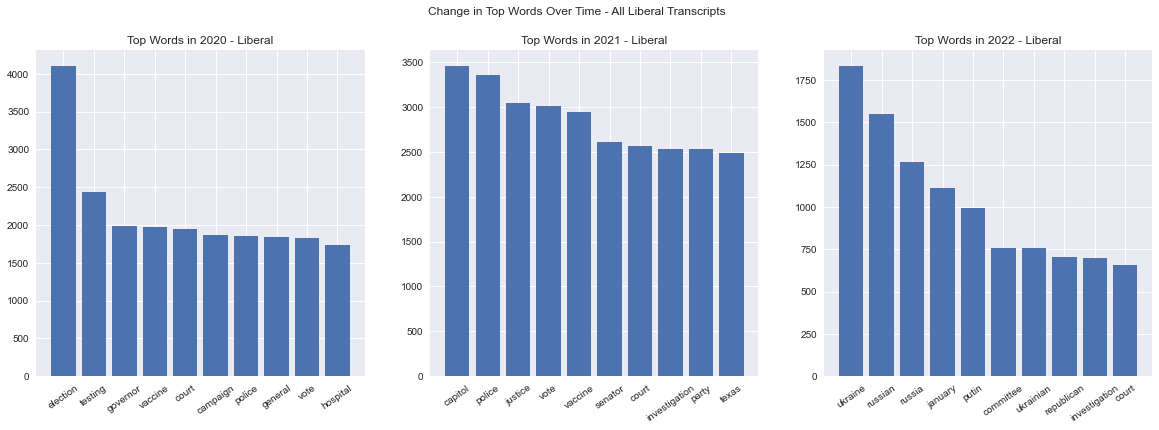

In [197]:
#create subplots
fig, axs = plt.subplots(1, 3, figsize=(20,6))

x_2020_liberal = top_10_words_2020_liberal.keys()
y_2020_liberal = top_10_words_2020_liberal.values()

x_2021_liberal = top_10_words_2021_liberal.keys()
y_2021_liberal = top_10_words_2021_liberal.values()

x_2022_liberal = top_10_words_2022_liberal.keys()
y_2022_liberal = top_10_words_2022_liberal.values()


fig.suptitle('Change in Top Words Over Time - All Liberal Transcripts')
axs[0].bar(x_2020_liberal,y_2020_liberal)#.xticks(rotation=45)
axs[0].set_title('Top Words in 2020 - Liberal')
axs[0].set_xticklabels(x_2020_liberal, rotation=35)


axs[1].bar(x_2021_liberal,y_2021_liberal)
axs[1].set_title('Top Words in 2021 - Liberal')
axs[1].set_xticklabels(x_2021_liberal, rotation=35)


axs[2].bar(x_2022_liberal,y_2022_liberal)
axs[2].set_title('Top Words in 2022 - Liberal')
axs[2].set_xticklabels(x_2022_liberal, rotation=35)

#fig.savefig(repo_path +'/images/change-over-time-full.png')

In [198]:
#---------- YEAR OVER YEAR ANALYSIS FOR THE CONSERVATIVE CORPUS
X_2020_conservative, X_transformed_2020_conservative, array_of_words_2020_conservative, array_of_counts_2020_conservative, word_frequency_dictionary_2020_conservative = countvec(text_transcripts_2020_conservative, full_stop_words_conservative)
X_2021_conservative, X_transformed_2021_conservative, array_of_words_2021_conservative, array_of_counts_2021_conservative, word_frequency_dictionary_2021_conservative = countvec(text_transcripts_2021_conservative, full_stop_words_conservative)
X_2022_conservative, X_transformed_2022_conservative, array_of_words_2022_conservative, array_of_counts_2022_conservative, word_frequency_dictionary_2022_conservative = countvec(text_transcripts_2022_conservative, full_stop_words_conservative)

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [199]:
# vocabulary length
print("There are {:,} unique words in the conservative vocabulary for 2020.".format(len(X_2020_conservative.vocabulary_)))
print("There are {:,} unique words in the conservative vocabulary for 2021.".format(len(X_2021_conservative.vocabulary_)))
print("There are {:,} unique words in the conservative vocabulary for 2022.".format(len(X_2022_conservative.vocabulary_)))

There are 4,789 unique words in the conservative vocabulary for 2020.
There are 5,004 unique words in the conservative vocabulary for 2021.
There are 6,867 unique words in the conservative vocabulary for 2022.


In [200]:
#check to see if "coronavirus" is in the dictionary, print index
vocab_2020_conservative = X_2020_conservative.vocabulary_
vocab_2021_conservative = X_2021_conservative.vocabulary_
vocab_2022_conservative = X_2022_conservative.vocabulary_

#vocab_2020["coronavirus"] we see the same thing in the conservative corpus, which is really surprising
vocab_2021_conservative['coronavirus']

1002

In [201]:
#set the number of top words to see
num_top_words = 10

top_10_words_2020_conservative = dict(sorted(word_frequency_dictionary_2020_conservative.items(), key = itemgetter(1), reverse = True)[:num_top_words])
top_10_words_2021_conservative = dict(sorted(word_frequency_dictionary_2021_conservative.items(), key = itemgetter(1), reverse = True)[:num_top_words])
top_10_words_2022_conservative = dict(sorted(word_frequency_dictionary_2022_conservative.items(), key = itemgetter(1), reverse = True)[:num_top_words])

print(top_10_words_2020_conservative)
print(top_10_words_2021_conservative)
print(top_10_words_2022_conservative)

{'police': 1163, 'china': 639, 'black': 616, 'campaign': 559, 'health': 557, 'male': 543, 'economy': 450, 'covid': 447, 'governor': 446, 'vote': 427}
{'police': 1351, 'vaccine': 1285, 'border': 1264, 'school': 1155, 'vaccinated': 1049, 'crime': 1013, 'afghanistan': 903, 'mask': 900, 'shes': 889, 'children': 870}
{'ukraine': 317, 'russia': 221, 'black': 186, 'war': 178, 'judge': 173, 'putin': 172, 'crime': 165, 'police': 155, 'trump': 153, 'border': 149}


/var/folders/l8/t9x4mbrd2qz1gg4gt4t9rttc0000gn/T/ipykernel_50262/1404586589.py:17: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[0].set_xticklabels(x_2020_conservative, rotation=35)
/var/folders/l8/t9x4mbrd2qz1gg4gt4t9rttc0000gn/T/ipykernel_50262/1404586589.py:22: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[1].set_xticklabels(x_2021_conservative, rotation=35)
/var/folders/l8/t9x4mbrd2qz1gg4gt4t9rttc0000gn/T/ipykernel_50262/1404586589.py:27: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[2].set_xticklabels(x_2022_conservative, rotation=35)


[Text(0, 0, 'ukraine'),
 Text(1, 0, 'russia'),
 Text(2, 0, 'black'),
 Text(3, 0, 'war'),
 Text(4, 0, 'judge'),
 Text(5, 0, 'putin'),
 Text(6, 0, 'crime'),
 Text(7, 0, 'police'),
 Text(8, 0, 'trump'),
 Text(9, 0, 'border')]

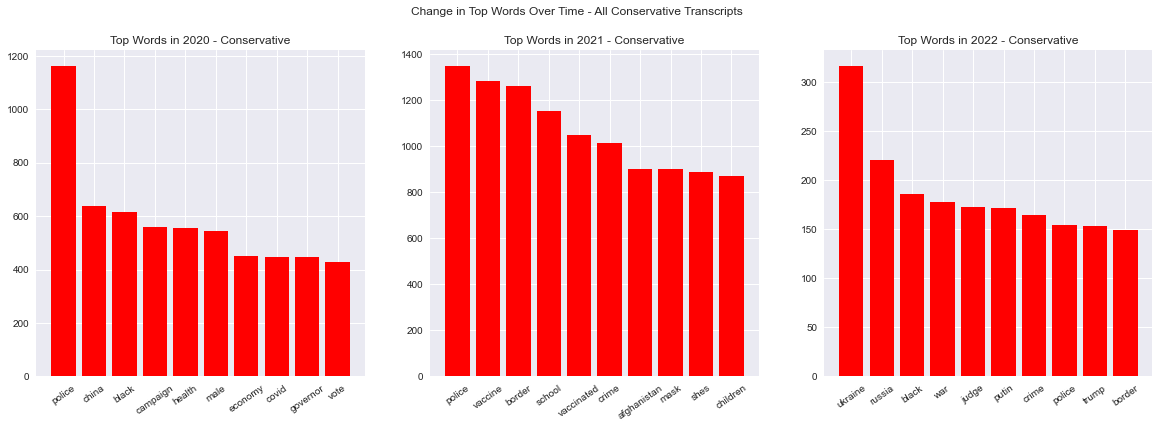

In [202]:
#create subplots
fig, axs = plt.subplots(1, 3, figsize=(20,6))

x_2020_conservative = top_10_words_2020_conservative.keys()
y_2020_conservative = top_10_words_2020_conservative.values()

x_2021_conservative = top_10_words_2021_conservative.keys()
y_2021_conservative = top_10_words_2021_conservative.values()

x_2022_conservative = top_10_words_2022_conservative.keys()
y_2022_conservative = top_10_words_2022_conservative.values()


fig.suptitle('Change in Top Words Over Time - All Conservative Transcripts')
axs[0].bar(x_2020_conservative,y_2020_conservative, color = 'red')#.xticks(rotation=45)
axs[0].set_title('Top Words in 2020 - Conservative')
axs[0].set_xticklabels(x_2020_conservative, rotation=35)


axs[1].bar(x_2021_conservative,y_2021_conservative, color = 'red')
axs[1].set_title('Top Words in 2021 - Conservative')
axs[1].set_xticklabels(x_2021_conservative, rotation=35)


axs[2].bar(x_2022_conservative,y_2022_conservative, color = 'red')
axs[2].set_title('Top Words in 2022 - Conservative')
axs[2].set_xticklabels(x_2022_conservative, rotation=35)

#fig.savefig(repo_path +'/images/conservative-change-over-time-full.png')

# Analysis #2: Co-Occurrence Analysis <a name="a2"></a>

The code chunks below conduct co-occurrence analysis within each corpus. For each corpus, the transcripts are parsed using spaCy. Next, lemma counts for all words and co-occurrence counts for COVID, mask, and vaccine terms are counted, allowing for various PMI calculations printed below.

## Liberal - Transcript Co-Occurrence <a name="a2liberaltrans"></a>

In [203]:
# instantiate nlp
nlp = spacy.load('en_core_web_sm', disable = ['ner', 'parser'])

In [204]:
%%time
# nlp parse transcripts
nlp_list_trans_liberal = [nlp(text) for text in text_transcripts_liberal]

CPU times: user 9min 31s, sys: 1min 21s, total: 10min 52s
Wall time: 11min 25s


In [205]:
# create counters
lemma_counter_liberal = Counter()
covid_co_counter_liberal = Counter()
covid_count_liberal = 0
mask_co_counter_liberal = Counter()
mask_count_liberal = 0
vaccine_co_counter_liberal = Counter()
vaccine_count_liberal = 0

# for each document, add unique lemmas to counter
# increase co-occurrence and covid counter if covid terms overlap lemma set
# same for mask terms, vaccine terms
for transcript in nlp_list_trans_liberal:
    lemmas = {token.lemma_.lower() for token in transcript}
    lemma_counter_liberal.update(lemmas)
    if not lemmas.isdisjoint(set(covid_terms)):
        covid_co_counter_liberal.update(lemmas)
        covid_count_liberal += 1
    if not lemmas.isdisjoint(set(mask_terms)):
        mask_co_counter_liberal.update(lemmas)
        mask_count_liberal += 1
    if not lemmas.isdisjoint(set(vaccine_terms)):
        vaccine_co_counter_liberal.update(lemmas)
        vaccine_count_liberal += 1

In [206]:
# calculate COVID terms PMI
# P(covid)
covid_ratio_liberal = covid_count_liberal / len(nlp_list_trans_liberal)

# calculate PMI only for words that co-occur
pmi_covid_liberal = list()
for lemma, count in covid_co_counter_liberal.items():
    
    lemma_ratio = lemma_counter_liberal[lemma] / len(nlp_list_trans_liberal) # P(lemma)
    co_ratio = covid_co_counter_liberal[lemma] / len(nlp_list_trans_liberal) # P(covid, lemma)
    
    # store lemma, total lemma count, co-occur count, and PMI
    pmi_covid_liberal += [(lemma, lemma_counter_liberal[lemma], covid_co_counter_liberal[lemma], 
                   np.log2(co_ratio / (covid_ratio_liberal * lemma_ratio)))]

# sort list of tuples by pmi then by lemma count, descending
pmi_covid_sort_liberal = sorted(pmi_covid_liberal, key = lambda x: [round(x[3], 5), x[1]], reverse = True)

In [207]:
# calculate mask terms PMI
# P(mask)
mask_ratio_liberal = mask_count_liberal / len(nlp_list_trans_liberal)

# calculate PMI only for words that co-occur
pmi_mask_liberal = list()
for lemma, count in mask_co_counter_liberal.items():
    
    lemma_ratio = lemma_counter_liberal[lemma] / len(nlp_list_trans_liberal) # P(lemma)
    co_ratio = mask_co_counter_liberal[lemma] / len(nlp_list_trans_liberal) # P(mask, lemma)
    
    # store lemma, total lemma count, co-occur count, and PMI
    pmi_mask_liberal += [(lemma, lemma_counter_liberal[lemma], mask_co_counter_liberal[lemma], 
                   np.log2(co_ratio / (mask_ratio_liberal * lemma_ratio)))]

# sort list of tuples by pmi then by lemma count, descending
pmi_mask_sort_liberal = sorted(pmi_mask_liberal, key = lambda x: [round(x[3], 5), x[1]], reverse = True)

In [208]:
# calculate vaccine terms PMI
# P(vaccine)
vaccine_ratio_liberal = vaccine_count_liberal / len(nlp_list_trans_liberal)

# calculate PMI only for words that co-occur
pmi_vaccine_liberal = list()
for lemma, count in vaccine_co_counter_liberal.items():
    
    lemma_ratio = lemma_counter_liberal[lemma] / len(nlp_list_trans_liberal) # P(lemma)
    co_ratio = vaccine_co_counter_liberal[lemma] / len(nlp_list_trans_liberal) # P(vaccine, lemma)
    
    # store lemma, total lemma count, co-occur count, and PMI
    pmi_vaccine_liberal += [(lemma, lemma_counter_liberal[lemma], vaccine_co_counter_liberal[lemma], 
                   np.log2(co_ratio / (vaccine_ratio_liberal * lemma_ratio)))]

# sort list of tuples by pmi then by lemma count, descending
pmi_vaccine_sort_liberal = sorted(pmi_vaccine_liberal, key = lambda x: [round(x[3], 5), x[1]], reverse = True)

In [209]:
# print top words (by PMI) that co-occur with COVID terms - break ties arbitrarily
counter = 0
print('Top Words that Co-Occur with COVID Terms in Liberal Transcripts')
print('{:<25} {:<15} {:<15} {:<15}'.format('Word', 'Word Count', 'Co-Occur Count', 'PMI'))
print('-' * 70)
for lemma in pmi_covid_sort_liberal:
    if (lemma[0] not in full_stop_words_liberal) and (lemma[0] not in covid_terms) and (counter < 30):
        print('{:<25} {:<15} {:<15} {:<15}'.format(lemma[0], lemma[1], lemma[2], round(lemma[3], 5)))
        counter += 1

Top Words that Co-Occur with COVID Terms in Liberal Transcripts
Word                      Word Count      Co-Occur Count  PMI            
----------------------------------------------------------------------
infection                 432             432             0.20249        
symptom                   263             263             0.20249        
epidemic                  241             241             0.20249        
variant                   232             232             0.20249        
icu                       217             217             0.20249        
indoor                    185             185             0.20249        
ventilator                175             175             0.20249        
antibody                  152             152             0.20249        
unvaccinated              136             136             0.20249        
contagious                130             130             0.20249        
ppe                       124             124      

In [210]:
# print top words (by PMI) that co-occur with COVID terms given that lemma count > 30% of transcripts
counter = 0
print('Top Words that Co-Occur with COVID Terms in Liberal Transcripts, Given that Word Occurs in At Least 30% of Transcripts')
print('{:<25} {:<15} {:<15} {:<15}'.format('Word', 'Word Count', 'Co-Occur Count', 'PMI'))
print('-' * 70)
for lemma in pmi_covid_sort_liberal:
    if (lemma[0] not in full_stop_words_liberal) and (lemma[0] not in covid_terms) and (counter < 30) and (lemma[1] > round(0.30 * len(text_transcripts_liberal))):
        print('{:<25} {:<15} {:<15} {:<15}'.format(lemma[0], lemma[1], lemma[2], round(lemma[3], 5)))
        counter += 1

Top Words that Co-Occur with COVID Terms in Liberal Transcripts, Given that Word Occurs in At Least 30% of Transcripts
Word                      Word Count      Co-Occur Count  PMI            
----------------------------------------------------------------------
infection                 432             432             0.20249        
hospitalization           355             354             0.19842        
cdc                       382             380             0.19492        
infect                    405             402             0.19177        
testing                   376             372             0.18706        
disease                   464             459             0.18686        
vaccine                   619             610             0.18136        
vaccination               320             315             0.17977        
sick                      448             437             0.16663        
surge                     359             350             0.16586     

In [211]:
# print top words (by PMI) that co-occur with mask terms - break ties arbitrarily
counter = 0
print('Top Words that Co-Occur with Mask Terms in Liberal Transcripts')
print('{:<25} {:<15} {:<15} {:<15}'.format('Word', 'Word Count', 'Co-Occur Count', 'PMI'))
print('-' * 70)
for lemma in pmi_mask_sort_liberal:
    if (lemma[0] not in full_stop_words_liberal) and (lemma[0] not in mask_terms) and (counter < 30):
        print('{:<25} {:<15} {:<15} {:<15}'.format(lemma[0], lemma[1], lemma[2], round(lemma[3], 5)))
        counter += 1

Top Words that Co-Occur with Mask Terms in Liberal Transcripts
Word                      Word Count      Co-Occur Count  PMI            
----------------------------------------------------------------------
antigen                   24              24              0.65085        
meatpacking               23              23              0.65085        
reuse                     22              22              0.65085        
remdesivir                21              21              0.65085        
ihme                      19              19              0.65085        
floridian                 19              19              0.65085        
sebelius                  17              17              0.65085        
reagent                   16              16              0.65085        
stayat                    15              15              0.65085        
asthma                    15              15              0.65085        
facemask                  15              15        

In [212]:
# print top words (by PMI) that co-occur with mask terms given that lemma count > 30% of transcripts
counter = 0
print('Top Words that Co-Occur with Mask Terms in Liberal Transcripts, Given that Word Occurs in At Least 30% of Transcripts')
print('{:<25} {:<15} {:<15} {:<15}'.format('Word', 'Word Count', 'Co-Occur Count', 'PMI'))
print('-' * 70)
for lemma in pmi_mask_sort_liberal:
    if (lemma[0] not in full_stop_words_liberal) and (lemma[0] not in mask_terms) and (counter < 30) and (lemma[1] > round(0.30 * len(text_transcripts_liberal))):
        print('{:<25} {:<15} {:<15} {:<15}'.format(lemma[0], lemma[1], lemma[2], round(lemma[3], 5)))
        counter += 1

Top Words that Co-Occur with Mask Terms in Liberal Transcripts, Given that Word Occurs in At Least 30% of Transcripts
Word                      Word Count      Co-Occur Count  PMI            
----------------------------------------------------------------------
testing                   376             324             0.43611        
infection                 432             359             0.3838         
wear                      611             500             0.36161        
disease                   464             379             0.35892        
infect                    405             330             0.35539        
hospitalization           355             287             0.34408        
science                   391             315             0.33903        
patient                   432             348             0.33891        
virus                     582             468             0.33634        
positive                  469             369             0.30488      

In [213]:
# print top words (by PMI) that co-occur with vaccine terms - break ties arbitrarily
counter = 0
print('Top Words that Co-Occur with Vaccine Terms in Liberal Transcripts')
print('{:<25} {:<15} {:<15} {:<15}'.format('Word', 'Word Count', 'Co-Occur Count', 'PMI'))
print('-' * 70)
for lemma in pmi_vaccine_sort_liberal:
    if (lemma[0] not in full_stop_words_liberal) and (lemma[0] not in vaccine_terms) and (counter < 30):
        print('{:<25} {:<15} {:<15} {:<15}'.format(lemma[0], lemma[1], lemma[2], round(lemma[3], 5)))
        counter += 1

Top Words that Co-Occur with Vaccine Terms in Liberal Transcripts
Word                      Word Count      Co-Occur Count  PMI            
----------------------------------------------------------------------
unvaccinated              136             136             0.52195        
transmissible             71              71              0.52195        
unvaccinate               66              66              0.52195        
placebo                   39              39              0.52195        
immunization              34              34              0.52195        
immunocompromise          30              30              0.52195        
epidemiology              27              27              0.52195        
lyndon                    24              24              0.52195        
uptake                    23              23              0.52195        
satan                     23              23              0.52195        
transmissibility          22              22     

In [214]:
# print top words (by PMI) that co-occur with vaccine terms given that lemma count > 30% of transcripts
counter = 0
print('Top Words that Co-Occur with Vaccine Terms in Liberal Transcripts, Given that Word Occurs in At Least 30% of Transcripts')
print('{:<25} {:<15} {:<15} {:<15}'.format('Word', 'Word Count', 'Co-Occur Count', 'PMI'))
print('-' * 70)
for lemma in pmi_vaccine_sort_liberal:
    if (lemma[0] not in full_stop_words_liberal) and (lemma[0] not in vaccine_terms) and (counter < 30) and (lemma[1] > round(0.30 * len(text_transcripts_liberal))):
        print('{:<25} {:<15} {:<15} {:<15}'.format(lemma[0], lemma[1], lemma[2], round(lemma[3], 5)))
        counter += 1

Top Words that Co-Occur with Vaccine Terms in Liberal Transcripts, Given that Word Occurs in At Least 30% of Transcripts
Word                      Word Count      Co-Occur Count  PMI            
----------------------------------------------------------------------
vaccinate                 385             374             0.48013        
cdc                       382             322             0.27544        
science                   391             327             0.26407        
hospitalization           355             296             0.25973        
disease                   464             386             0.25643        
infection                 432             356             0.2428         
infect                    405             331             0.23086        
datum                     550             444             0.21308        
study                     418             337             0.2112         
shot                      467             376             0.20926   

## Conservative - Transcript Co-Occurrence <a name="a2conservativetrans"></a>

In [215]:
%%time
# nlp parse transcripts
nlp_list_trans_conservative = [nlp(text) for text in text_transcripts_conservative]

CPU times: user 4min 24s, sys: 38.4 s, total: 5min 2s
Wall time: 6min 1s


In [216]:
# create counters
lemma_counter_conservative = Counter()
covid_co_counter_conservative = Counter()
covid_count_conservative = 0
mask_co_counter_conservative = Counter()
mask_count_conservative = 0
vaccine_co_counter_conservative = Counter()
vaccine_count_conservative = 0

# for each document, add unique lemmas to counter
# increase co-occurrence and covid counter if covid terms overlap lemma set
# same for mask terms, vaccine terms
for transcript in nlp_list_trans_conservative:
    lemmas = {token.lemma_.lower() for token in transcript}
    lemma_counter_conservative.update(lemmas)
    if not lemmas.isdisjoint(set(covid_terms)):
        covid_co_counter_conservative.update(lemmas)
        covid_count_conservative += 1
    if not lemmas.isdisjoint(set(mask_terms)):
        mask_co_counter_conservative.update(lemmas)
        mask_count_conservative += 1
    if not lemmas.isdisjoint(set(vaccine_terms)):
        vaccine_co_counter_conservative.update(lemmas)
        vaccine_count_conservative += 1

In [217]:
# calculate COVID terms PMI
# P(covid)
covid_ratio_conservative = covid_count_conservative / len(nlp_list_trans_conservative)

# calculate PMI only for words that co-occur
pmi_covid_conservative = list()
for lemma, count in covid_co_counter_conservative.items():
    
    lemma_ratio = lemma_counter_conservative[lemma] / len(nlp_list_trans_conservative) # P(lemma)
    co_ratio = covid_co_counter_conservative[lemma] / len(nlp_list_trans_conservative) # P(covid, lemma)
    
    # store lemma, total lemma count, co-occur count, and PMI
    pmi_covid_conservative += [(lemma, lemma_counter_conservative[lemma], covid_co_counter_conservative[lemma], 
                   np.log2(co_ratio / (covid_ratio_conservative * lemma_ratio)))]

# sort list of tuples by pmi then by lemma count, descending
pmi_covid_sort_conservative = sorted(pmi_covid_conservative, key = lambda x: [round(x[3], 5), x[1]], reverse = True)

In [218]:
# calculate mask terms PMI
# P(mask)
mask_ratio_conservative = mask_count_conservative / len(nlp_list_trans_conservative)

# calculate PMI only for words that co-occur
pmi_mask_conservative = list()
for lemma, count in mask_co_counter_conservative.items():
    
    lemma_ratio = lemma_counter_conservative[lemma] / len(nlp_list_trans_conservative) # P(lemma)
    co_ratio = mask_co_counter_conservative[lemma] / len(nlp_list_trans_conservative) # P(mask, lemma)
    
    # store lemma, total lemma count, co-occur count, and PMI
    pmi_mask_conservative += [(lemma, lemma_counter_conservative[lemma], mask_co_counter_conservative[lemma], 
                   np.log2(co_ratio / (mask_ratio_conservative * lemma_ratio)))]

# sort list of tuples by pmi then by lemma count, descending
pmi_mask_sort_conservative = sorted(pmi_mask_conservative, key = lambda x: [round(x[3], 5), x[1]], reverse = True)

In [219]:
# calculate vaccine terms PMI
# P(vaccine)
vaccine_ratio_conservative = vaccine_count_conservative / len(nlp_list_trans_conservative)

# calculate PMI only for words that co-occur
pmi_vaccine_conservative = list()
for lemma, count in vaccine_co_counter_conservative.items():
    
    lemma_ratio = lemma_counter_conservative[lemma] / len(nlp_list_trans_conservative) # P(lemma)
    co_ratio = vaccine_co_counter_conservative[lemma] / len(nlp_list_trans_conservative) # P(vaccine, lemma)
    
    # store lemma, total lemma count, co-occur count, and PMI
    pmi_vaccine_conservative += [(lemma, lemma_counter_conservative[lemma], vaccine_co_counter_conservative[lemma], 
                   np.log2(co_ratio / (vaccine_ratio_conservative * lemma_ratio)))]

# sort list of tuples by pmi then by lemma count, descending
pmi_vaccine_sort_conservative = sorted(pmi_vaccine_conservative, key = lambda x: [round(x[3], 5), x[1]], reverse = True)

In [220]:
# print top words (by PMI) that co-occur with COVID terms - break ties arbitrarily
counter = 0
print('Top Words that Co-Occur with COVID Terms in Conservative Transcripts')
print('{:<25} {:<15} {:<15} {:<15}'.format('Word', 'Word Count', 'Co-Occur Count', 'PMI'))
print('-' * 70)
for lemma in pmi_covid_sort_conservative:
    if (lemma[0] not in full_stop_words_conservative) and (lemma[0] not in covid_terms) and (counter < 30):
        print('{:<25} {:<15} {:<15} {:<15}'.format(lemma[0], lemma[1], lemma[2], round(lemma[3], 5)))
        counter += 1

Top Words that Co-Occur with COVID Terms in Conservative Transcripts
Word                      Word Count      Co-Occur Count  PMI            
----------------------------------------------------------------------
science                   250             250             0.07765        
lockdown                  148             148             0.07765        
infect                    136             136             0.07765        
infection                 118             118             0.07765        
criticism                 107             107             0.07765        
quarantine                102             102             0.07765        
testing                   102             102             0.07765        
infectious                98              98              0.07765        
scientific                94              94              0.07765        
distancing                92              92              0.07765        
boss                      89              89  

In [221]:
# print top words (by PMI) that co-occur with COVID terms given that lemma count > 30% of transcripts
counter = 0
print('Top Words that Co-Occur with COVID Terms in Conservative Transcripts, Given that Word Occurs in At Least 30% of Transcripts')
print('{:<25} {:<15} {:<15} {:<15}'.format('Word', 'Word Count', 'Co-Occur Count', 'PMI'))
print('-' * 70)
for lemma in pmi_covid_sort_conservative:
    if (lemma[0] not in full_stop_words_conservative) and (lemma[0] not in covid_terms) and (counter < 30) and (lemma[1] > round(0.30 * len(text_transcripts_conservative))):
        print('{:<25} {:<15} {:<15} {:<15}'.format(lemma[0], lemma[1], lemma[2], round(lemma[3], 5)))
        counter += 1

Top Words that Co-Occur with COVID Terms in Conservative Transcripts, Given that Word Occurs in At Least 30% of Transcripts
Word                      Word Count      Co-Occur Count  PMI            
----------------------------------------------------------------------
science                   250             250             0.07765        
lockdown                  148             148             0.07765        
disease                   207             206             0.07067        
mask                      331             329             0.06891        
research                  152             151             0.06813        
vaccine                   270             268             0.06693        
travel                    182             180             0.06171        
vaccinate                 178             176             0.06135        
positive                  170             168             0.06058        
teach                     163             161             0.05984

In [222]:
# print top words (by PMI) that co-occur with mask terms - break ties arbitrarily
counter = 0
print('Top Words that Co-Occur with Mask Terms in Conservative Transcripts')
print('{:<25} {:<15} {:<15} {:<15}'.format('Word', 'Word Count', 'Co-Occur Count', 'PMI'))
print('-' * 70)
for lemma in pmi_mask_sort_conservative:
    if (lemma[0] not in full_stop_words_conservative) and (lemma[0] not in mask_terms) and (counter < 30):
        print('{:<25} {:<15} {:<15} {:<15}'.format(lemma[0], lemma[1], lemma[2], round(lemma[3], 5)))
        counter += 1

Top Words that Co-Occur with Mask Terms in Conservative Transcripts
Word                      Word Count      Co-Occur Count  PMI            
----------------------------------------------------------------------
maskless                  32              32              0.34335        
irrational                25              25              0.34335        
xenophobic                19              19              0.34335        
moderna                   19              19              0.34335        
rky                       18              18              0.34335        
sergeant                  18              18              0.34335        
goodbye                   18              18              0.34335        
wellknown                 17              17              0.34335        
surgical                  17              17              0.34335        
antivaxxer                17              17              0.34335        
jab                       17              17   

In [223]:
# print top words (by PMI) that co-occur with mask terms given that lemma count > 30% of transcripts
counter = 0
print('Top Words that Co-Occur with COVID Terms in Conservative Transcripts, Given that Word Occurs in At Least 30% of Transcripts')
print('{:<25} {:<15} {:<15} {:<15}'.format('Word', 'Word Count', 'Co-Occur Count', 'PMI'))
print('-' * 70)
for lemma in pmi_mask_sort_conservative:
    if (lemma[0] not in full_stop_words_conservative) and (lemma[0] not in mask_terms) and (counter < 30) and (lemma[1] > round(0.30 * len(text_transcripts_conservative))):
        print('{:<25} {:<15} {:<15} {:<15}'.format(lemma[0], lemma[1], lemma[2], round(lemma[3], 5)))
        counter += 1

Top Words that Co-Occur with COVID Terms in Conservative Transcripts, Given that Word Occurs in At Least 30% of Transcripts
Word                      Word Count      Co-Occur Count  PMI            
----------------------------------------------------------------------
wear                      329             294             0.18108        
mandate                   200             178             0.17523        
viewer                    146             129             0.16475        
vaccine                   270             237             0.15528        
foot                      170             149             0.15313        
vaccinate                 178             156             0.15302        
science                   250             219             0.15235        
disease                   207             181             0.14971        
institute                 151             131             0.13837        
lockdown                  148             128             0.1339 

In [224]:
# print top words (by PMI) that co-occur with vaccine terms - break ties arbitrarily
counter = 0
print('Top Words that Co-Occur with Vaccine Terms in Conservative Transcripts')
print('{:<25} {:<15} {:<15} {:<15}'.format('Word', 'Word Count', 'Co-Occur Count', 'PMI'))
print('-' * 70)
for lemma in pmi_vaccine_sort_conservative:
    if (lemma[0] not in full_stop_words_conservative) and (lemma[0] not in vaccine_terms) and (counter < 30):
        print('{:<25} {:<15} {:<15} {:<15}'.format(lemma[0], lemma[1], lemma[2], round(lemma[3], 5)))
        counter += 1

Top Words that Co-Occur with Vaccine Terms in Conservative Transcripts
Word                      Word Count      Co-Occur Count  PMI            
----------------------------------------------------------------------
unvaccinated              79              79              0.56774        
unvaccinate               31              31              0.56774        
neurotic                  17              17              0.56774        
antivaxxer                17              17              0.56774        
jab                       17              17              0.56774        
boris                     16              16              0.56774        
hesitancy                 15              15              0.56774        
gig                       15              15              0.56774        
antivax                   14              14              0.56774        
positivity                14              14              0.56774        
neanderthal               14              14

In [225]:
# print top words (by PMI) that co-occur with vaccine terms given that lemma count > 30% of transcripts
counter = 0
print('Top Words that Co-Occur with Vaccine Terms in Conservative Transcripts, Given that Word Occurs in At Least 30% of Transcripts')
print('{:<25} {:<15} {:<15} {:<15}'.format('Word', 'Word Count', 'Co-Occur Count', 'PMI'))
print('-' * 70)
for lemma in pmi_vaccine_sort_conservative:
    if (lemma[0] not in full_stop_words_conservative) and (lemma[0] not in vaccine_terms) and (counter < 30) and (lemma[1] > round(0.30 * len(text_transcripts_conservative))):
        print('{:<25} {:<15} {:<15} {:<15}'.format(lemma[0], lemma[1], lemma[2], round(lemma[3], 5)))
        counter += 1

Top Words that Co-Occur with Vaccine Terms in Conservative Transcripts, Given that Word Occurs in At Least 30% of Transcripts
Word                      Word Count      Co-Occur Count  PMI            
----------------------------------------------------------------------
vaccinate                 178             170             0.5014         
mandate                   200             178             0.39962        
com                       182             146             0.24977        
transcription             284             223             0.21889        
viq                       284             223             0.21889        
fully                     170             133             0.21363        
immigrant                 141             110             0.20955        
nearly                    187             143             0.18072        
science                   250             191             0.17939        
shot                      215             163             0.168

## CDC - Transcript Co-Occurrence <a name="a2cdctrans"></a>

In [226]:
# instantiate nlp
nlp = spacy.load('en_core_web_sm', disable = ['ner', 'parser'])

In [227]:
%%time
# nlp parse transcripts
nlp_list_trans_cdc = [nlp(text) for text in text_transcripts_cdc]

CPU times: user 8.39 s, sys: 1.08 s, total: 9.47 s
Wall time: 9.88 s


In [228]:
# create counters
lemma_counter_cdc = Counter()
covid_co_counter_cdc = Counter()
covid_count_cdc = 0
mask_co_counter_cdc = Counter()
mask_count_cdc = 0
vaccine_co_counter_cdc = Counter()
vaccine_count_cdc = 0

# for each document, add unique lemmas to counter
# increase co-occurrence and covid counter if covid terms overlap lemma set
# same for mask terms, vaccine terms
for transcript in nlp_list_trans_cdc:
    lemmas = {token.lemma_.lower() for token in transcript}
    lemma_counter_cdc.update(lemmas)
    if not lemmas.isdisjoint(set(covid_terms)):
        covid_co_counter_cdc.update(lemmas)
        covid_count_cdc += 1
    if not lemmas.isdisjoint(set(mask_terms)):
        mask_co_counter_cdc.update(lemmas)
        mask_count_cdc += 1
    if not lemmas.isdisjoint(set(vaccine_terms)):
        vaccine_co_counter_cdc.update(lemmas)
        vaccine_count_cdc += 1

In [229]:
# calculate COVID terms PMI
# P(covid)
covid_ratio_cdc = covid_count_cdc / len(nlp_list_trans_cdc)

# calculate PMI only for words that co-occur
pmi_covid_cdc = list()
for lemma, count in covid_co_counter_cdc.items():
    
    lemma_ratio = lemma_counter_cdc[lemma] / len(nlp_list_trans_cdc) # P(lemma)
    co_ratio = covid_co_counter_cdc[lemma] / len(nlp_list_trans_cdc) # P(covid, lemma)
    
    # store lemma, total lemma count, co-occur count, and PMI
    pmi_covid_cdc += [(lemma, lemma_counter_cdc[lemma], covid_co_counter_cdc[lemma], 
                   np.log2(co_ratio / (covid_ratio_cdc * lemma_ratio)))]

# sort list of tuples by pmi then by lemma count, descending
pmi_covid_sort_cdc = sorted(pmi_covid_cdc, key = lambda x: [round(x[3], 5), x[1]], reverse = True)

In [230]:
# calculate mask terms PMI
# P(mask)
mask_ratio_cdc = mask_count_cdc / len(nlp_list_trans_cdc)

# calculate PMI only for words that co-occur
pmi_mask_cdc = list()
for lemma, count in mask_co_counter_cdc.items():
    
    lemma_ratio = lemma_counter_cdc[lemma] / len(nlp_list_trans_cdc) # P(lemma)
    co_ratio = mask_co_counter_cdc[lemma] / len(nlp_list_trans_cdc) # P(mask, lemma)
    
    # store lemma, total lemma count, co-occur count, and PMI
    pmi_mask_cdc += [(lemma, lemma_counter_cdc[lemma], mask_co_counter_cdc[lemma], 
                   np.log2(co_ratio / (mask_ratio_cdc * lemma_ratio)))]

# sort list of tuples by pmi then by lemma count, descending
pmi_mask_sort_cdc = sorted(pmi_mask_cdc, key = lambda x: [round(x[3], 5), x[1]], reverse = True)

In [231]:
# calculate vaccine terms PMI
# P(vaccine)
vaccine_ratio_cdc = vaccine_count_cdc / len(nlp_list_trans_cdc)

# calculate PMI only for words that co-occur
pmi_vaccine_cdc = list()
for lemma, count in vaccine_co_counter_cdc.items():
    
    lemma_ratio = lemma_counter_cdc[lemma] / len(nlp_list_trans_cdc) # P(lemma)
    co_ratio = vaccine_co_counter_cdc[lemma] / len(nlp_list_trans_cdc) # P(vaccine, lemma)
    
    # store lemma, total lemma count, co-occur count, and PMI
    pmi_vaccine_cdc += [(lemma, lemma_counter_cdc[lemma], vaccine_co_counter_cdc[lemma], 
                   np.log2(co_ratio / (vaccine_ratio_cdc * lemma_ratio)))]

# sort list of tuples by pmi then by lemma count, descending
pmi_vaccine_sort_cdc = sorted(pmi_vaccine_cdc, key = lambda x: [round(x[3], 5), x[1]], reverse = True)

In [232]:
# print top words (by PMI) that co-occur with COVID terms - break ties arbitrarily
counter = 0
print('Top Words that Co-Occur with COVID Terms in CDC Transcripts')
print('{:<25} {:<15} {:<15} {:<15}'.format('Word', 'Word Count', 'Co-Occur Count', 'PMI'))
print('-' * 70)
for lemma in pmi_covid_sort_cdc:
    if (lemma[0] not in full_stop_words_cdc) and (lemma[0] not in covid_terms) and (counter < 30):
        print('{:<25} {:<15} {:<15} {:<15}'.format(lemma[0], lemma[1], lemma[2], round(lemma[3], 5)))
        counter += 1

Top Words that Co-Occur with COVID Terms in CDC Transcripts
Word                      Word Count      Co-Occur Count  PMI            
----------------------------------------------------------------------
follow                    36              36              0.03103        
provide                   35              35              0.03103        
important                 34              34              0.03103        
health                    33              33              0.03103        
disease                   32              32              0.03103        
recommendation            31              31              0.03103        
available                 30              30              0.03103        
like                      30              30              0.03103        
director                  30              30              0.03103        
high                      30              30              0.03103        
continue                  30              30           

In [233]:
# print top words (by PMI) that co-occur with COVID terms given that lemma count > 30% of transcripts
counter = 0
print('Top Words that Co-Occur with COVID Terms in CDC Transcripts, Given that Word Occurs in At Least 30% of Transcripts')
print('{:<25} {:<15} {:<15} {:<15}'.format('Word', 'Word Count', 'Co-Occur Count', 'PMI'))
print('-' * 70)
for lemma in pmi_covid_sort_cdc:
    if (lemma[0] not in full_stop_words_cdc) and (lemma[0] not in covid_terms) and (counter < 30) and (lemma[1] > round(0.30 * len(text_transcripts_cdc))):
        print('{:<25} {:<15} {:<15} {:<15}'.format(lemma[0], lemma[1], lemma[2], round(lemma[3], 5)))
        counter += 1

Top Words that Co-Occur with COVID Terms in CDC Transcripts, Given that Word Occurs in At Least 30% of Transcripts
Word                      Word Count      Co-Occur Count  PMI            
----------------------------------------------------------------------
follow                    36              36              0.03103        
provide                   35              35              0.03103        
important                 34              34              0.03103        
health                    33              33              0.03103        
disease                   32              32              0.03103        
recommendation            31              31              0.03103        
available                 30              30              0.03103        
like                      30              30              0.03103        
director                  30              30              0.03103        
high                      30              30              0.03103        


In [234]:
# print top words (by PMI) that co-occur with mask terms - break ties arbitrarily
counter = 0
print('Top Words that Co-Occur with Mask Terms in CDC Transcripts')
print('{:<25} {:<15} {:<15} {:<15}'.format('Word', 'Word Count', 'Co-Occur Count', 'PMI'))
print('-' * 70)
for lemma in pmi_mask_sort_cdc:
    if (lemma[0] not in full_stop_words_cdc) and (lemma[0] not in mask_terms) and (counter < 30):
        print('{:<25} {:<15} {:<15} {:<15}'.format(lemma[0], lemma[1], lemma[2], round(lemma[3], 5)))
        counter += 1

Top Words that Co-Occur with Mask Terms in CDC Transcripts
Word                      Word Count      Co-Occur Count  PMI            
----------------------------------------------------------------------
indoor                    9               9               1.46713        
distancing                8               8               1.46713        
friend                    8               8               1.46713        
wash                      7               7               1.46713        
substantial               6               6               1.46713        
spend                     6               6               1.46713        
ventilation               5               5               1.46713        
cbs                       5               5               1.46713        
practical                 5               5               1.46713        
survey                    5               5               1.46713        
student                   5               5             

In [235]:
# print top words (by PMI) that co-occur with mask terms given that lemma count > 30% of transcripts
counter = 0
print('Top Words that Co-Occur with Mask Terms in CDC Transcripts, Given that Word Occurs in At Least 30% of Transcripts')
print('{:<25} {:<15} {:<15} {:<15}'.format('Word', 'Word Count', 'Co-Occur Count', 'PMI'))
print('-' * 70)
for lemma in pmi_mask_sort_cdc:
    if (lemma[0] not in full_stop_words_cdc) and (lemma[0] not in mask_terms) and (counter < 30) and (lemma[1] > round(0.30 * len(text_transcripts_cdc))):
        print('{:<25} {:<15} {:<15} {:<15}'.format(lemma[0], lemma[1], lemma[2], round(lemma[3], 5)))
        counter += 1

Top Words that Co-Occur with Mask Terms in CDC Transcripts, Given that Word Occurs in At Least 30% of Transcripts
Word                      Word Count      Co-Occur Count  PMI            
----------------------------------------------------------------------
wear                      15              14              1.36759        
area                      17              12              0.96463        
share                     17              12              0.96463        
hand                      20              14              0.95255        
critical                  16              11              0.92656        
hope                      18              12              0.88216        
stay                      18              12              0.88216        
example                   15              10              0.88216        
maybe                     15              10              0.88216        
consider                  15              10              0.88216        
d

In [236]:
# print top words (by PMI) that co-occur with vaccine terms - break ties arbitrarily
counter = 0
print('Top Words that Co-Occur with Vaccine Terms in CDC Transcripts')
print('{:<25} {:<15} {:<15} {:<15}'.format('Word', 'Word Count', 'Co-Occur Count', 'PMI'))
print('-' * 70)
for lemma in pmi_vaccine_sort_cdc:
    if (lemma[0] not in full_stop_words_cdc) and (lemma[0] not in vaccine_terms) and (counter < 30):
        print('{:<25} {:<15} {:<15} {:<15}'.format(lemma[0], lemma[1], lemma[2], round(lemma[3], 5)))
        counter += 1

Top Words that Co-Occur with Vaccine Terms in CDC Transcripts
Word                      Word Count      Co-Occur Count  PMI            
----------------------------------------------------------------------
vaccinate                 14              14              0.7997         
advisory                  13              13              0.7997         
dose                      11              11              0.7997         
committee                 10              10              0.7997         
acip                      9               9               0.7997         
variant                   8               8               0.7997         
primary                   7               7               0.7997         
rapid                     7               7               0.7997         
senior                    7               7               0.7997         
authorize                 7               7               0.7997         
thousand                  7               7          

In [237]:
# print top words (by PMI) that co-occur with vaccine terms given that lemma count > 30% of transcripts
counter = 0
print('Top Words that Co-Occur with Vaccine Terms in CDC Transcripts, Given that Word Occurs in At Least 30% of Transcripts')
print('{:<25} {:<15} {:<15} {:<15}'.format('Word', 'Word Count', 'Co-Occur Count', 'PMI'))
print('-' * 70)
for lemma in pmi_vaccine_sort_cdc:
    if (lemma[0] not in full_stop_words_cdc) and (lemma[0] not in vaccine_terms) and (counter < 30) and (lemma[1] > round(0.30 * len(text_transcripts_cdc))):
        print('{:<25} {:<15} {:<15} {:<15}'.format(lemma[0], lemma[1], lemma[2], round(lemma[3], 5)))
        counter += 1

Top Words that Co-Occur with Vaccine Terms in CDC Transcripts, Given that Word Occurs in At Least 30% of Transcripts
Word                      Word Count      Co-Occur Count  PMI            
----------------------------------------------------------------------
review                    16              14              0.60706        
million                   15              13              0.59325        
add                       17              14              0.51959        
fully                     16              13              0.50014        
severe                    20              16              0.47777        
maybe                     15              12              0.47777        
increase                  24              19              0.46267        
ahead                     18              14              0.43713        
practice                  22              17              0.42773        
safe                      17              13              0.41268       

## A Note on Sentence Co-Occurrence <a name="a2sents"></a>

In addition to transcript-level co-occurrence, we also analyzed co-occurrence with COVID, mask, and vaccine terms within sentences. The results of the sentence-level co-occurrence analysis did not yield anything significantly different than the transcript-level analysis. Therefore, we did not include the results here but they are available on our project's GitHub page, located here: https://github.com/tobijegede/opinion-news-nlp.

# Analysis #3: Topic Modeling <a name="a3"></a>

We conduct topic modeling using LDA for the liberal corpus, conservative corpus, and CDC corpus. Top words for the resulting topics are printed and are displayed in word clouds. We also explored using different numbers of topics, which can be found on our project's GitHub page, located here: https://github.com/tobijegede/opinion-news-nlp.

## Liberal - Full Transcript Topic Modeling <a name="a3liberaltrans"></a>

In [238]:
# fit with 10 topics
num_topics = 10

lda = LatentDirichletAllocation(n_components = num_topics, 
                                random_state = 0)

lda.fit(X_transformed_trans_liberal)

LatentDirichletAllocation(random_state=0)

In [239]:
# normalize to get probability distributions
topic_word_dist_liberal = np.array([row / row.sum() for row in lda.components_])

In [240]:
# list top 20 words in each topic
for topic_idx in range(num_topics):
    print('\n', 'Topic ', topic_idx, ':', sep = '')
    sort_idx = np.argsort(-topic_word_dist_liberal[topic_idx])
    for rank in range(20):
        word_idx = sort_idx[rank]
        print('{:<80} {:<10}'.format(array_of_words_trans_liberal[word_idx], topic_word_dist_liberal[topic_idx, word_idx]))


Topic 0:
party                                                                            0.007136715748774689
republicans                                                                      0.006843630955710412
vote                                                                             0.006542620745871371
democrats                                                                        0.005186607784871236
vaccine                                                                          0.004695954891513027
break                                                                            0.004029563587151932
correspondent                                                                    0.004001168586907448
voters                                                                           0.0038743413311477255
campaign                                                                         0.003651937578805315
voting                                                                 

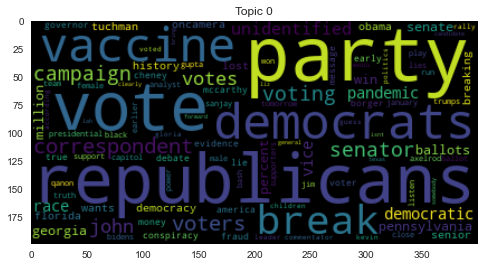

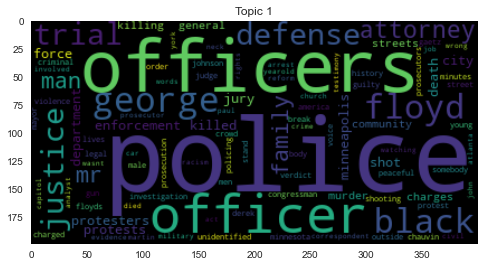

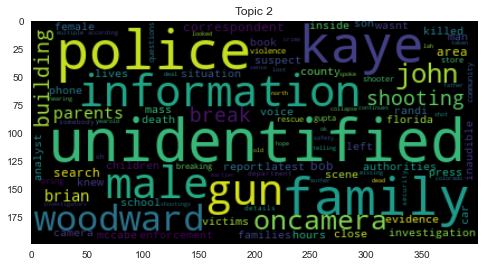

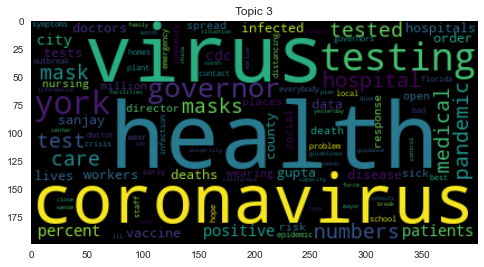

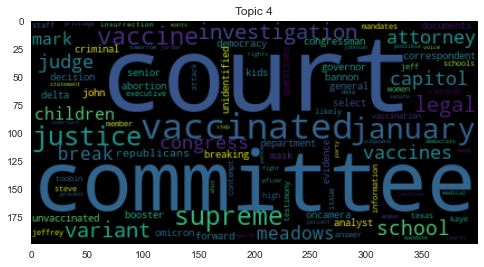

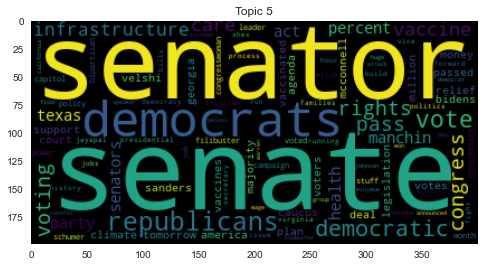

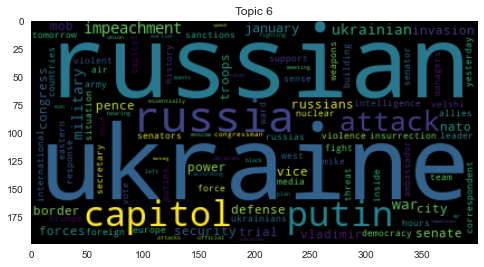

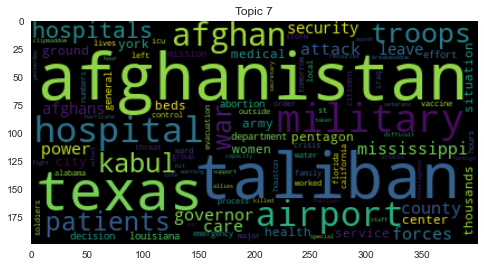

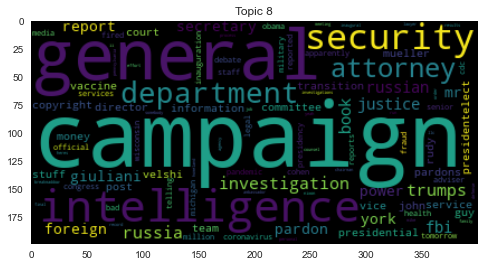

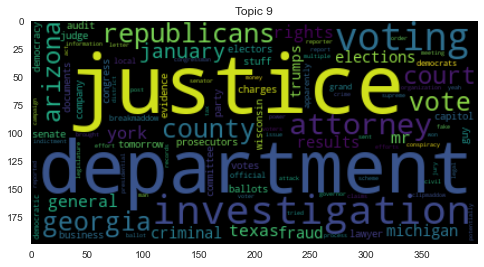

In [241]:
# wordclouds
for topic_idx in range(num_topics):
    wc = WordCloud(max_words = 100)
    wc.generate_from_frequencies(dict(zip(array_of_words_trans_liberal, topic_word_dist_liberal[topic_idx])))
    plt.figure()
    plt.imshow(wc, interpolation = 'bilinear')
    plt.title('Topic %d' % topic_idx)
    plt.grid(visible = None)

## Conservative - Full Transcript Topic Modeling <a name="a3conservativetrans"></a>

In [242]:
# fit with 10 topics
num_topics = 10

lda = LatentDirichletAllocation(n_components = num_topics, 
                                random_state = 0)

lda.fit(X_transformed_trans_conservative)

LatentDirichletAllocation(random_state=0)

In [243]:
# normalize to get probability distributions
topic_word_dist_conservative = np.array([row / row.sum() for row in lda.components_])

In [244]:
# list top 20 words in each topic
for topic_idx in range(num_topics):
    print('\n', 'Topic ', topic_idx, ':', sep = '')
    sort_idx = np.argsort(-topic_word_dist_conservative[topic_idx])
    for rank in range(20):
        word_idx = sort_idx[rank]
        print('{:<80} {:<10}'.format(array_of_words_trans_conservative[word_idx], topic_word_dist_conservative[topic_idx, word_idx]))


Topic 0:
coronavirus                                                                      0.01179254656432842
virus                                                                            0.009054398326794107
china                                                                            0.008280960149969225
health                                                                           0.005157503220115206
pandemic                                                                         0.004640970899554703
cases                                                                            0.004502119154657954
governor                                                                         0.004265841129174014
testing                                                                          0.00378493484179808
economy                                                                          0.0035338331464482946
test                                                                     

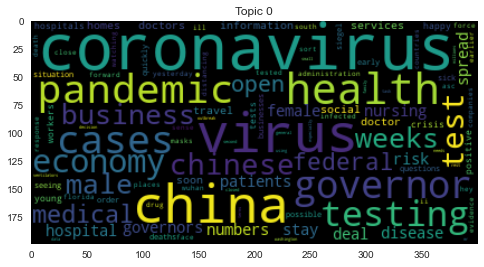

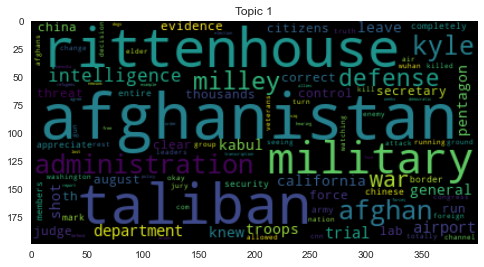

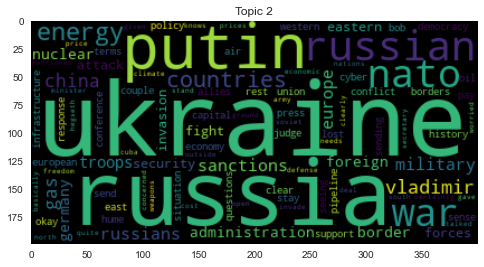

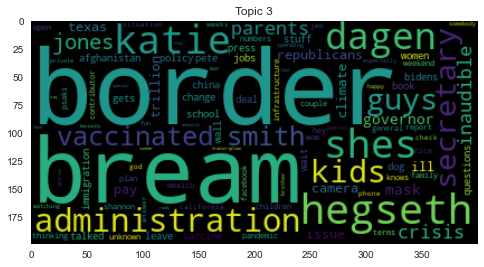

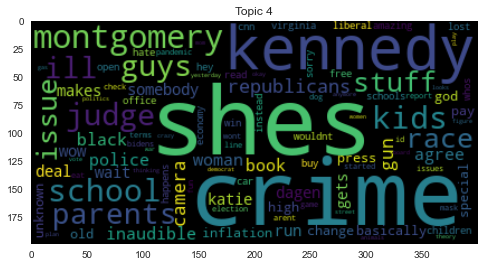

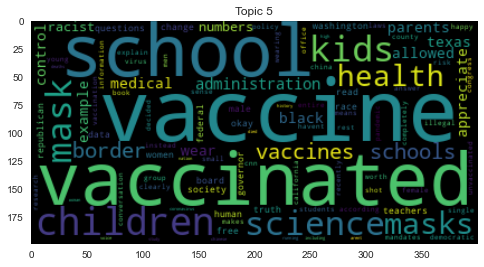

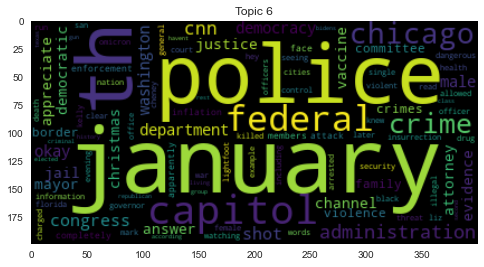

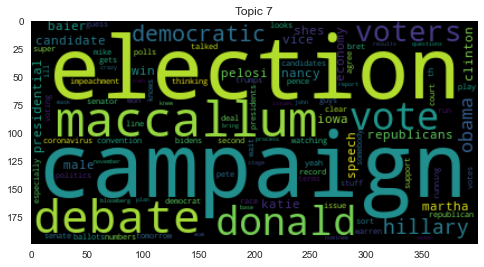

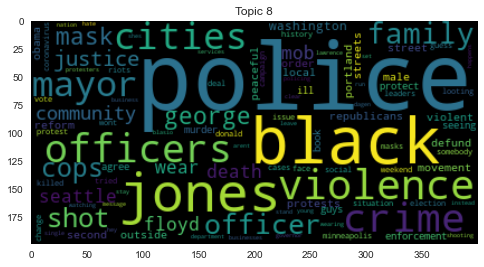

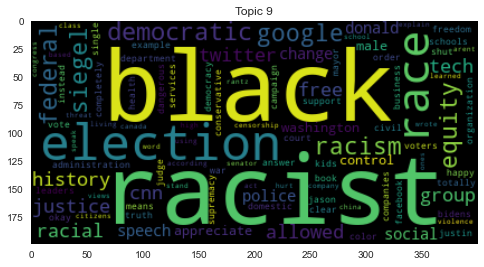

In [245]:
# wordclouds
for topic_idx in range(num_topics):
    wc = WordCloud(max_words = 100)
    wc.generate_from_frequencies(dict(zip(array_of_words_trans_conservative, topic_word_dist_conservative[topic_idx])))
    plt.figure()
    plt.imshow(wc, interpolation = 'bilinear')
    plt.title('Topic %d' % topic_idx)
    plt.grid(visible = None)

## CDC - Full Transcript Topic Modeling <a name="a3cdctrans"></a>

In [246]:
# fit with 5 topics
num_topics = 5

lda = LatentDirichletAllocation(n_components = num_topics, 
                                random_state = 0)

lda.fit(X_transformed_trans_cdc)

LatentDirichletAllocation(n_components=5, random_state=0)

In [247]:
# normalize to get probability distributions
topic_word_dist_cdc = np.array([row / row.sum() for row in lda.components_])

In [248]:
# list top 20 words in each topic
for topic_idx in range(num_topics):
    print('\n', 'Topic ', topic_idx, ':', sep = '')
    sort_idx = np.argsort(-topic_word_dist_cdc[topic_idx])
    for rank in range(20):
        word_idx = sort_idx[rank]
        print('{:<80} {:<10}'.format(array_of_words_trans_cdc[word_idx], topic_word_dist_cdc[topic_idx, word_idx]))


Topic 0:
risk                                                                             0.014473865543925489
think                                                                            0.01347385730393018
health                                                                           0.011014261031976265
know                                                                             0.010768904024455047
states                                                                           0.009045921965710933
public                                                                           0.008546812435937409
going                                                                            0.008500239889910255
like                                                                             0.007728584751192621
important                                                                        0.006881803500474036
cases                                                                    

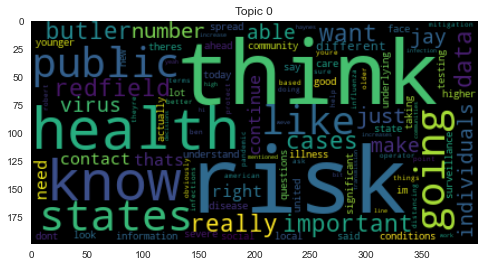

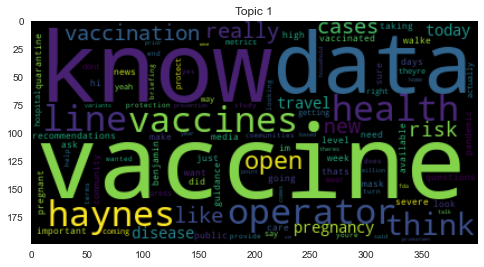

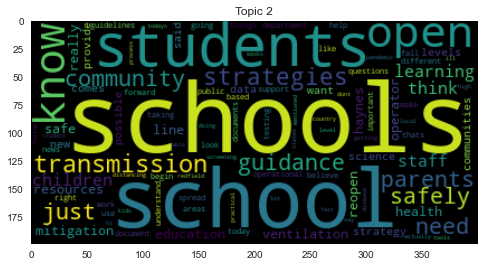

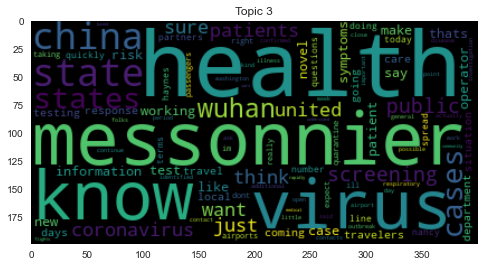

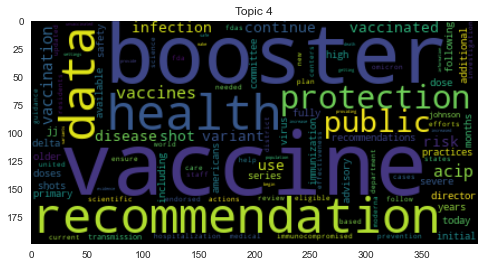

In [249]:
# wordclouds
for topic_idx in range(num_topics):
    wc = WordCloud(max_words = 100)
    wc.generate_from_frequencies(dict(zip(array_of_words_trans_cdc, topic_word_dist_cdc[topic_idx])))
    plt.figure()
    plt.imshow(wc, interpolation = 'bilinear')
    plt.title('Topic %d' % topic_idx)
    plt.grid(visible = None)

## Liberal - Restricted Transcript Topic Modeling <a name="a3liberaltransre"></a>

In [250]:
# fit with 15 topics
num_topics = 15

lda = LatentDirichletAllocation(n_components = num_topics, 
                                random_state = 0)

lda.fit(X_transformed_trans_liberal_cov)

LatentDirichletAllocation(n_components=15, random_state=0)

In [251]:
# normalize to get probability distributions
topic_word_dist_liberal_cov = np.array([row / row.sum() for row in lda.components_])

In [252]:
# list top 20 words in each topic
for topic_idx in range(num_topics):
    print('\n', 'Topic ', topic_idx, ':', sep = '')
    sort_idx = np.argsort(-topic_word_dist_liberal_cov[topic_idx])
    for rank in range(20):
        word_idx = sort_idx[rank]
        print('{:<80} {:<10}'.format(array_of_words_trans_liberal_cov[word_idx], topic_word_dist_liberal_cov[topic_idx, word_idx]))


Topic 0:
voting                                                                           0.011448542895999564
rights                                                                           0.009287459404210403
republicans                                                                      0.007603995744778513
texas                                                                            0.007522709404807692
senate                                                                           0.007263433445813665
democrats                                                                        0.006400183353105682
georgia                                                                          0.005936989285233883
vote                                                                             0.005335202991705157
county                                                                           0.004948216839236817
velshi                                                                  

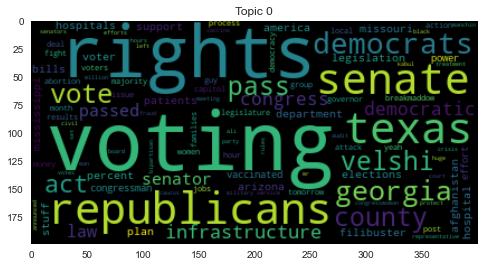

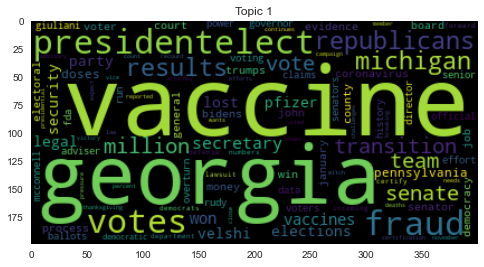

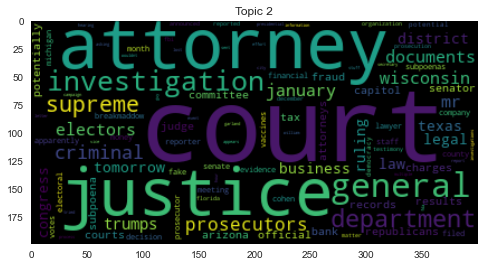

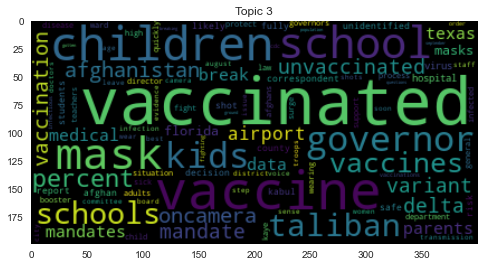

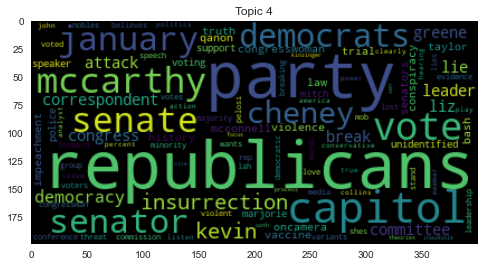

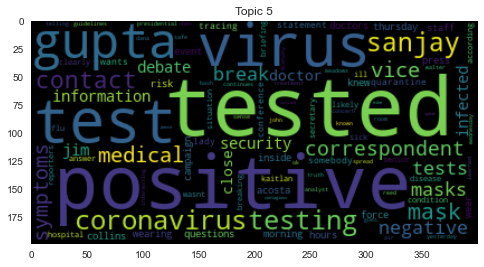

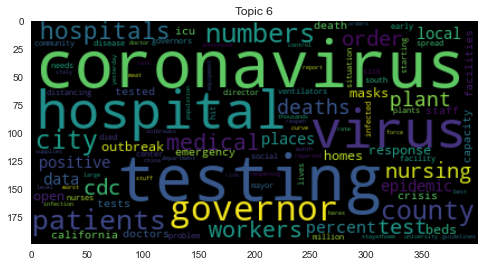

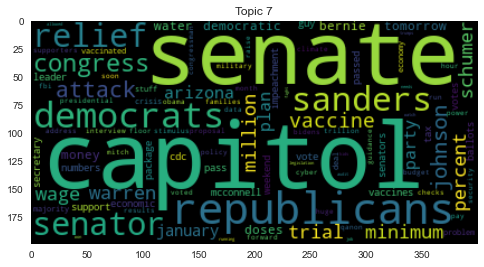

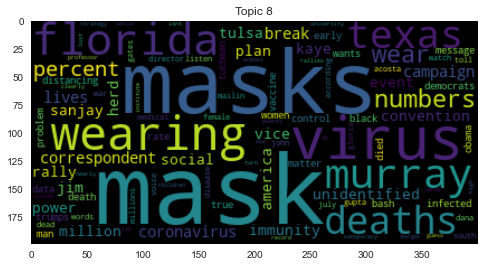

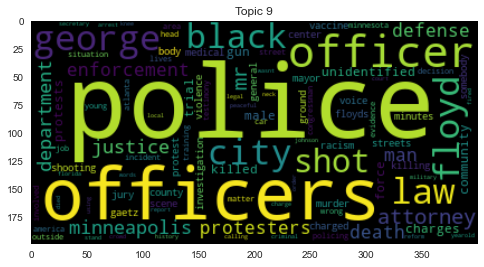

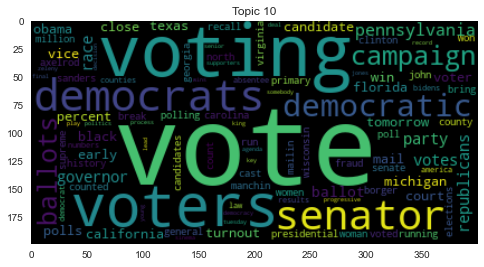

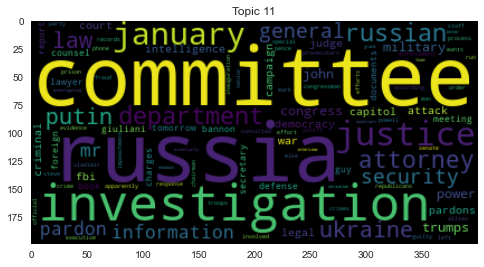

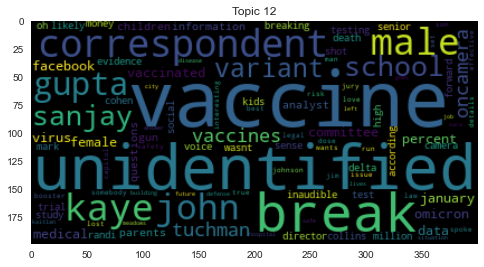

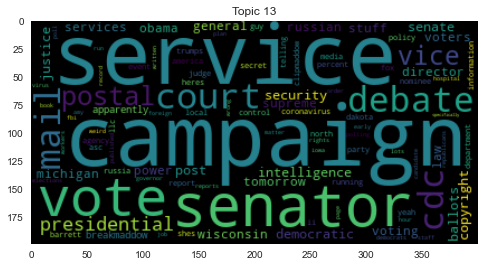

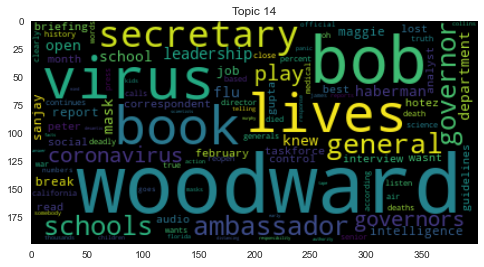

In [253]:
# wordclouds
for topic_idx in range(num_topics):
    wc = WordCloud(max_words = 100)
    wc.generate_from_frequencies(dict(zip(array_of_words_trans_liberal_cov, topic_word_dist_liberal_cov[topic_idx])))
    plt.figure()
    plt.imshow(wc, interpolation = 'bilinear')
    plt.title('Topic %d' % topic_idx)
    plt.grid(visible = None)

## Conservative - Restricted Transcript Topic Modeling <a name="a3conservativetransre"></a>

In [254]:
# fit with 15 topics
num_topics = 15

lda = LatentDirichletAllocation(n_components = num_topics, 
                                random_state = 0)

lda.fit(X_transformed_trans_conservative_cov)

LatentDirichletAllocation(n_components=15, random_state=0)

In [255]:
# normalize to get probability distributions
topic_word_dist_conservative_cov = np.array([row / row.sum() for row in lda.components_])

In [256]:
# list top 20 words in each topic
for topic_idx in range(num_topics):
    print('\n', 'Topic ', topic_idx, ':', sep = '')
    sort_idx = np.argsort(-topic_word_dist_conservative_cov[topic_idx])
    for rank in range(20):
        word_idx = sort_idx[rank]
        print('{:<80} {:<10}'.format(array_of_words_trans_conservative_cov[word_idx], topic_word_dist_conservative_cov[topic_idx, word_idx]))


Topic 0:
kennedy                                                                          0.01415443398053568
montgomery                                                                       0.010204563083217435
male                                                                             0.006260105540001198
flynn                                                                            0.00592803784512412
female                                                                           0.00560763079175501
open                                                                             0.0054588610486968865
obama                                                                            0.005200073941027656
deal                                                                             0.005106600109836523
campaign                                                                         0.005060083528140196
jobs                                                                      

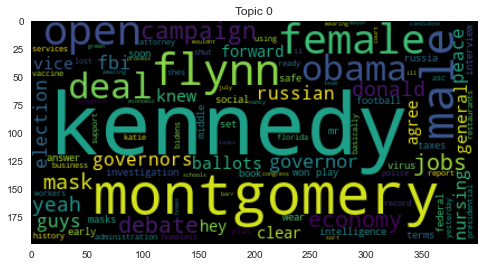

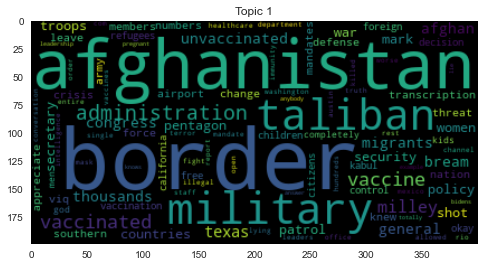

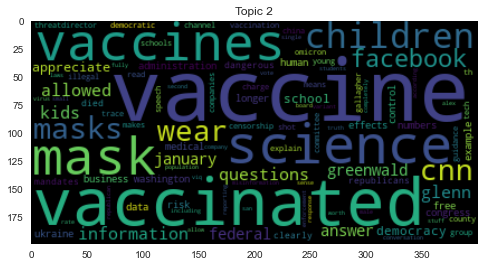

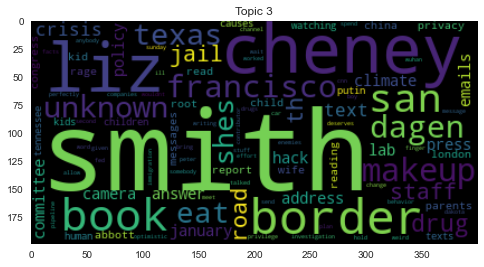

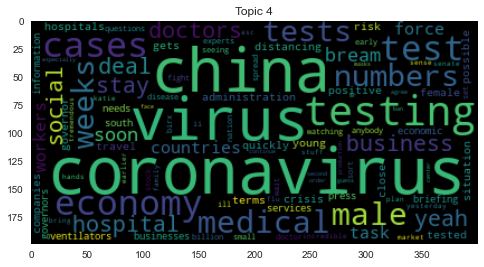

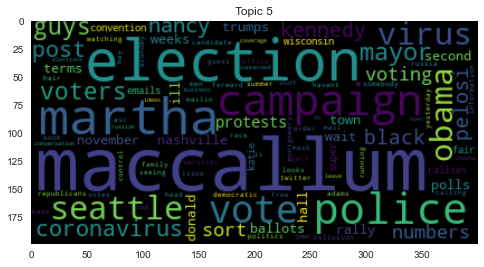

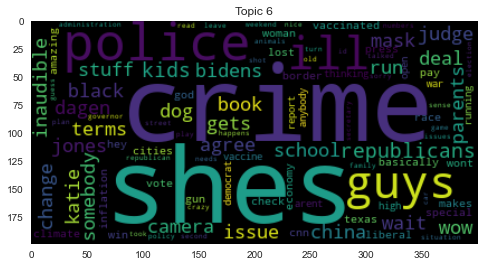

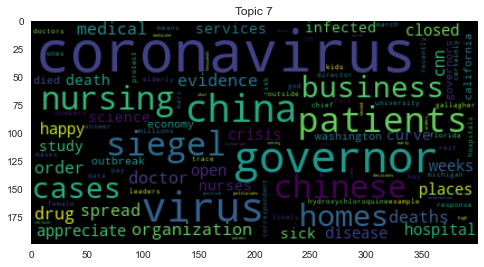

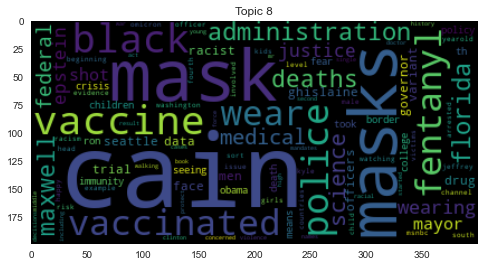

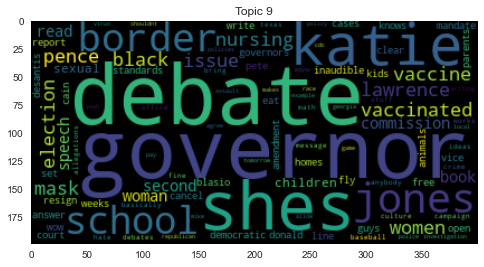

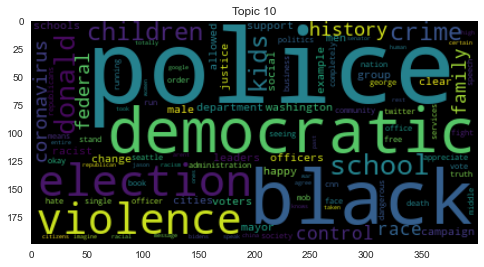

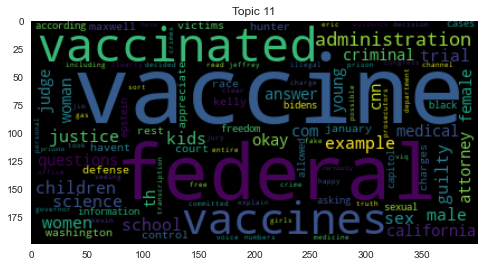

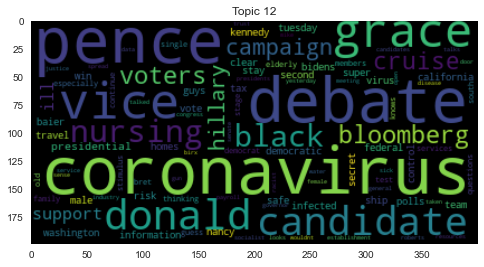

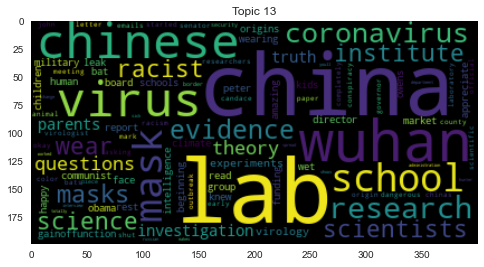

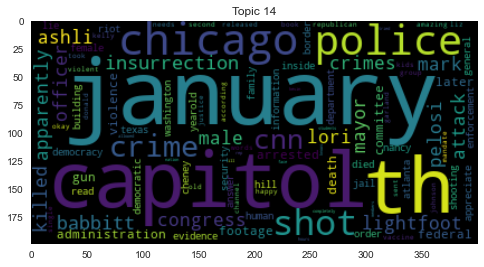

In [257]:
# wordclouds
for topic_idx in range(num_topics):
    wc = WordCloud(max_words = 100)
    wc.generate_from_frequencies(dict(zip(array_of_words_trans_conservative_cov, topic_word_dist_conservative_cov[topic_idx])))
    plt.figure()
    plt.imshow(wc, interpolation = 'bilinear')
    plt.title('Topic %d' % topic_idx)
    plt.grid(visible = None)

## CDC - Restricted Transcript Topic Modeling <a name="a3cdctransre"></a>

In [258]:
# fit with 5 topics
num_topics = 5

lda = LatentDirichletAllocation(n_components = num_topics, 
                                random_state = 0)

lda.fit(X_transformed_trans_cdc_cov)

LatentDirichletAllocation(n_components=5, random_state=0)

In [259]:
# normalize to get probability distributions
topic_word_dist_cdc_cov = np.array([row / row.sum() for row in lda.components_])

In [260]:
# list top 20 words in each topic
for topic_idx in range(num_topics):
    print('\n', 'Topic ', topic_idx, ':', sep = '')
    sort_idx = np.argsort(-topic_word_dist_cdc_cov[topic_idx])
    for rank in range(20):
        word_idx = sort_idx[rank]
        print('{:<80} {:<10}'.format(array_of_words_trans_cdc_cov[word_idx], topic_word_dist_cdc_cov[topic_idx, word_idx]))


Topic 0:
schools                                                                          0.021586634044320933
school                                                                           0.015397829848186863
know                                                                             0.010694258165306607
students                                                                         0.010643064116286903
open                                                                             0.010012475748855935
covid                                                                            0.00963417195929285
guidance                                                                         0.007398078252072955
transmission                                                                     0.0068694320956364
think                                                                            0.006644048095972502
haynes                                                                     

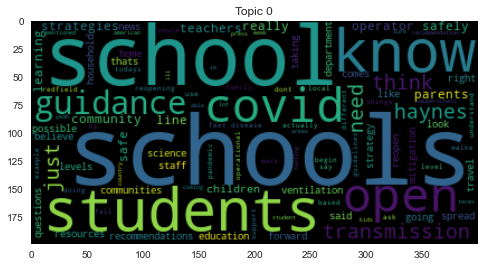

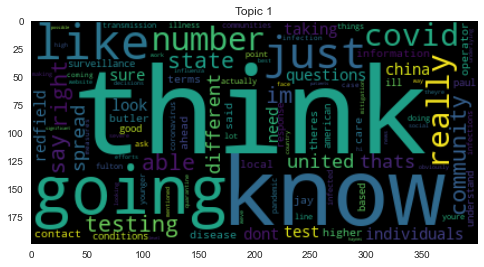

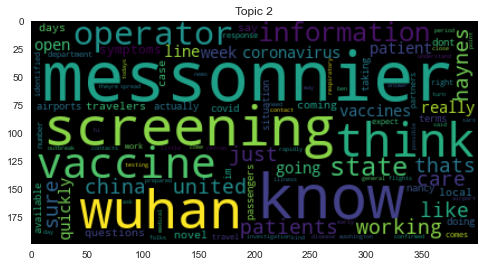

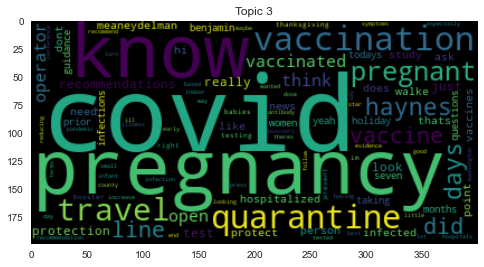

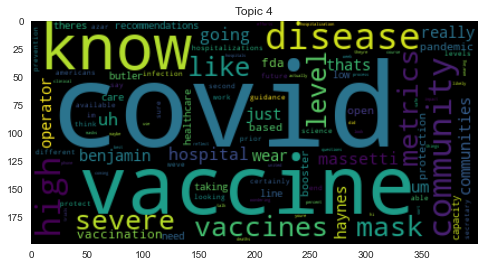

In [261]:
# wordclouds
for topic_idx in range(num_topics):
    wc = WordCloud(max_words = 100)
    wc.generate_from_frequencies(dict(zip(array_of_words_trans_cdc_cov, topic_word_dist_cdc_cov[topic_idx])))
    plt.figure()
    plt.imshow(wc, interpolation = 'bilinear')
    plt.title('Topic %d' % topic_idx)
    plt.grid(visible = None)

# Analysis #4: Sentiment Analysis <a name="a4"></a>

The key reason why we chose to do sentiment analysis as part of our project was because we theorized that, while conservative and liberal opinion talk shows hosts and their guests may use the same words, the tone and sentiment around those words could drastically differ. 

**Background:** For the sentiment analysis portion of our analysis, we used a method called **VADER** (Valence Aware Dictionary and sEntiment Reasoner). The associated python package for this method is **nltk.sentiment**. This method works best on small pieces of data, like sentences, rather than on a longer trasncript. Therefore, the analysis below is organized at the **sentence-level**. Also, because we used a pre-exisiting package, the methodology for assigning "positive" or "negative" sentiments to the sentiments is a bit of a black box to us. If we had further time for this project, we would explore other sentiment analysis packages and compare the results.




### Step 1: Subset the List of Sentences To Just Those That Include COVID Terms <a name="a41"></a>

The goal here is to better understand the context/sentiment around how covid is discussed in the liberal, conservative, and cdc corpora.

In [262]:
covid_sentences_liberal = [sentence for sentence in text_sentences_liberal if any(word in sentence for word in covid_terms)]
covid_sentences_conservative = [sentence for sentence in text_sentences_conservative if any(word in sentence for word in covid_terms)]
covid_sentences_cdc = [sentence for sentence in text_sentences_cdc if any(word in sentence for word in covid_terms)]

### Step 2: Apply the Sentiment Analyzer <a name="a42"></a>

In [263]:
sia = SentimentIntensityAnalyzer()

#define a function to run the sentiment analysis
def apply_sentiment_analysis(covid_sentences):
    total_compound_scores = []
    positive_sentences = []
    negative_sentences = []
    neutral_sentences = []
    #first 5 sentences test
    for sentence in covid_sentences:
        score = sia.polarity_scores(sentence)
        compound_score = score["compound"]
        total_compound_scores.append(compound_score)

        if compound_score == 0:
            neutral_sentences.append((sentence, score))
        elif compound_score > 0:
            positive_sentences.append((sentence, score))
        else: 
            negative_sentences.append((sentence, score))


    return total_compound_scores, positive_sentences, negative_sentences, neutral_sentences

In [264]:
#store all of the results from running sentiment analysis
total_compound_scores_liberal, positive_sentences_liberal, negative_sentences_liberal, neutral_sentences_liberal = apply_sentiment_analysis(covid_sentences_liberal)
total_compound_scores_conservative, positive_sentences_conservative, negative_sentences_conservative, neutral_sentences_conservative = apply_sentiment_analysis(covid_sentences_conservative)
total_compound_scores_cdc, positive_sentences_cdc, negative_sentences_cdc, neutral_sentences_cdc = apply_sentiment_analysis(covid_sentences_cdc)


### Step 3: Plot The Distribution of Sentence Sentiments <a name="a43"></a>

In [265]:
#create a function for ploting
def plot_sentiment_dist(positive, neutral, negative, pol_color, plot_title): #, filename):

    #fig = plt.figure() #added by Tobi to extract the graphics
    total_num_sentences = len(positive + neutral + negative)

    plt.style.use('seaborn')  

    x = ["positive", "neutral", "negative"]
    y = [len(positive)/total_num_sentences, len(neutral)/total_num_sentences, len(negative)/total_num_sentences]
    plt.bar(x,y, color = pol_color)
    plt.gca().yaxis.set_major_formatter(PercentFormatter(1)) #make the y-axis a percent
    plt.xlabel('Sentiment')
    plt.ylabel('Percent of Total Setences')
    plt.title(plot_title + " (Total Sentences = {:,})".format(total_num_sentences) )

    plt.show()

    #save the image
    #fig.savefig(filename)

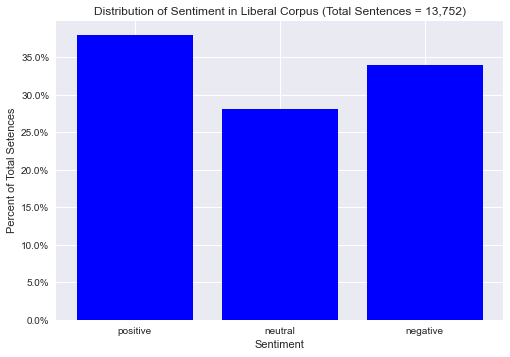

In [266]:
#plot the liberal sentiment analysis distribution
plot_sentiment_dist(positive_sentences_liberal, neutral_sentences_liberal, negative_sentences_liberal, "blue",'Distribution of Sentiment in Liberal Corpus')



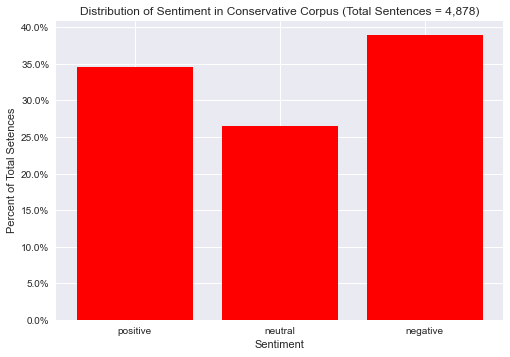

In [267]:
#plot the conservative sentiment analysis distribution
plot_sentiment_dist(positive_sentences_conservative, neutral_sentences_conservative, negative_sentences_conservative, "red", 'Distribution of Sentiment in Conservative Corpus')

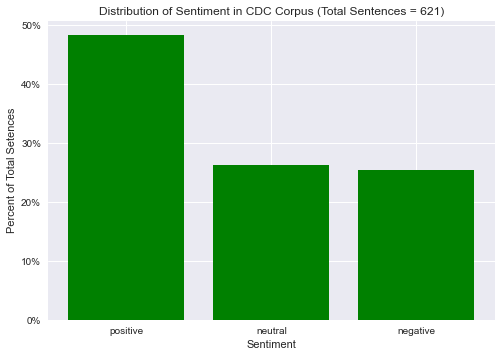

In [268]:
#plot the cdc sentiment analysis distribution
plot_sentiment_dist(positive_sentences_cdc, neutral_sentences_cdc, negative_sentences_cdc, "green",'Distribution of Sentiment in CDC Corpus')

### Step 4: List the Top 10 "Positive" and "Negative" Sentences <a name="a44"></a>

#### Top 10 Positive Sentences

In [269]:
positive_sentences_sort_liberal = sorted(positive_sentences_liberal, key = lambda x: x[1]["pos"], reverse = True)
positive_sentences_sort_conservative = sorted(positive_sentences_conservative, key = lambda x: x[1]["pos"], reverse = True)
positive_sentences_sort_cdc = sorted(positive_sentences_cdc, key = lambda x: x[1]["pos"], reverse = True)

top_10_positive_sentences_liberal = positive_sentences_sort_liberal[:10]
top_10_positive_sentences_conservative = positive_sentences_sort_conservative[:10]
top_10_positive_sentences_cdc = positive_sentences_sort_cdc[:10]


top_10_positive_sentences_liberal_only = [sentence  for sentence, score in top_10_positive_sentences_liberal]
top_10_positive_sentences_conservative_only = [sentence  for sentence, score in top_10_positive_sentences_conservative]
top_10_positive_sentences_cdc_only = [sentence  for sentence, score in top_10_positive_sentences_cdc]

for idx, sentences in enumerate(zip(top_10_positive_sentences_liberal_only, top_10_positive_sentences_conservative_only, top_10_positive_sentences_cdc_only)):
    liberal_sentence, conservative_sentence, cdc_sentence = sentences
   # print(idx, liberal_sentence, conservative_sentence)
    # sentence, score = combo
    # print(sentence)
    print("{}. Liberal: {} \n Conservative: {} \n CDC: {} \n".format(idx+1, liberal_sentence, conservative_sentence, cdc_sentence))


1. Liberal: comfvbebcovid relief 
 Conservative: like a virus 
 CDC: infection of novel coronavirus 

2. Liberal: covid relief was huge 
 Conservative: covid numbers his approval ratings on covid was pretty good 
 CDC: please visit the novel coronavirus webpage for continued updates 

3. Liberal: covid relief sees a huge number in support percent 
 Conservative: employees positive for coronavirus 
 CDC: im confident that covid vaccination is the way that we help 

4. Liberal: he survived coronavirus 
 Conservative: but like its a virus 
 CDC: thank you for joining us today for this briefing to discuss safe ways to enjoy the upcoming holidays amid the covid pandemic 

5. Liberal: hes promoted vaccines promoted masks promoted compassion for thoseliving with covid 
 Conservative: trillion covid relief package 
 CDC: im pleased to give an update on the ongoing novel coronavirus situation in the united states 

6. Liberal: well speak with a covid survivor 
 Conservative: trillion covid reli

#### Top 10 Negative Sentences

In [270]:
negative_sentences_sort_liberal = sorted(negative_sentences_liberal, key = lambda x: x[1]["pos"], reverse = True)
negative_sentences_sort_conservative = sorted(negative_sentences_conservative, key = lambda x: x[1]["pos"], reverse = True)
negative_sentences_sort_cdc = sorted(negative_sentences_cdc, key = lambda x: x[1]["pos"], reverse = True)

top_10_negative_sentences_liberal = negative_sentences_sort_liberal[:10]
top_10_negative_sentences_conservative = negative_sentences_sort_conservative[:10]
top_10_negative_sentences_cdc = negative_sentences_sort_cdc[:10]

top_10_negative_sentences_liberal_only = [sentence  for sentence, score in top_10_negative_sentences_liberal] #just takes the sentences from these lists
top_10_negative_sentences_conservative_only = [sentence  for sentence, score in top_10_negative_sentences_conservative]
top_10_negative_sentences_cdc_only = [sentence  for sentence, score in top_10_negative_sentences_cdc]


for idx, sentences in enumerate(zip(top_10_negative_sentences_liberal_only, top_10_negative_sentences_conservative_only, top_10_negative_sentences_cdc_only)):
    liberal_sentence, conservative_sentence, cdc_sentence = sentences
  
    print("{}. Liberal: {} \n Conservative: {} \n CDC: {} \n".format(idx+1, liberal_sentence, conservative_sentence, cdc_sentence))


1. Liberal: is winning the war against coronavirus 
 Conservative: a chinese flu virus please 
 CDC: this is another crucial step to help stop the spread of covid and to protect populations that have been put at increased risk of getting sick and dying from covid 

2. Liberal: the war against covid is far from won 
 Conservative: i have the freedom to kill you with my covid 
 CDC: cases of covid in symptomatic pregnant people have a twofold risk of admission into intensive care and a percent increased risk of death 

3. Liberal: its truly a war with this virus 
 Conservative: patricia cornwall was clearly very talented but two years of insane coronavirus restrictions broke her spirit 
 CDC: covid vaccine safety is a top priority for the federal government and we take all reports of health problems following covid vaccination very seriously 

4. Liberal: clearly covid is not terrorism but it has brought terror 
 Conservative: the framing of the fight against coronavirus as a war and ame

### Note about Sentiment Analysis

We initially tried to subset the datasets even further to just include transcripts that have mostly "positive" sentences and mostly "negative" sentences in order to then do some additional topic modeling. In doing this analysis, we found that the key takeaways from the topics generated were not meaningfully different than the topic modeling that was previously conducted above. Therefore, in this final, consolidated version of our analyis, we omitted this work. If you would like to see our results from this omitted section, please visit our project repository on Github: https://github.com/tobijegede/opinion-news-nlp.

# Policy Implications <a name="policy"></a>

**COVID-19 Liberal news network themes and concerns**
1. **Liberal news networks focused more on the state of the pandemic**
    - Terms used: *cases, deaths, datum, science, hospitalization, surge*
2. **Liberal news also reported on COVID safety protocol information**
    - Terms used: *distancing, vaccine, shot, doctor, effective, testing*

**COVID-19 Conservative news network themes and concerns**
1. **Conservative news reported on the business repercussions of COVID policies**
    - Terms used: *restaurant, company, shut, business, mandate, lockdown*
2. **Conservative news also focused on how COVID impacts personal freedom**
    - Terms used: *free, force, rule*

**Broad Takeaways**

Liberal and conservative opinion news shows are important sources of information for the public during the COVID-19 pandemic. While they sometimes use the same words, this analysis cannot distinguish differences in tone or broader context. Still, this analysis can distill differences in general themes, such as the liberal focus on the state of the pandemic and safety protocols, and the conservative focus on economic and personal freedom ramifications.

The CDC and other federal agencies should consider these prevailing sentiments when crafting COVID-19 public health policies and messaging. These analyses can reveal a lot about public opinion, which in turn can suggest how the public would respond to new policies and procedures. With this information in hand, the CDC can be equipped to create policies that are most likely to result in the best possible levels of compliance and success. For example, the CDC can create public health policies that aim to reduce spread of the virus while also considering impacts on local businesses.

**Federal Government and CDC policy changes to increase mask and vaccine compliance**
1. **Incentivize following CDC masking guidelines with:**
    - A policy that provides federal financial support from the Small Business Administration for businesses that follow CDC masking guidelines.
    - A policy that provides federal funding from the US Department of Education to school districts that follow CDC masking guidelines.
2. **Incentivize following CDC vaccine guidelines with:**
    - A policy that rewards getting vaccinated with a small, monetary award (such as a $100 check from the federal government).
    - A policy that provides one additional child tax credit payment for each child vaccinated in a household for the year they are vaccinated.

# Future Work & Analysis Limitations <a name="future"></a>

If given more time, we would attempt to adjust our analysis in the following ways:
1. Look at transcripts of **local news channels** instead of national news channels to get a better approximation of localized opinions about COVID-19 and its associated mitigation strategies. 
2. Expand analysis to look more at **change over time** in the coverage of COVID-19 under different presidential administrations instead of lumping both administrations together. The goal of this would be to see how the discussion of the pandemic has changed over time and how the tone shifted for each administration.
3. By just doing text analysis, the **context** and **tone** surrounding the words is absent. We attempted to remedy this issue through sentiment analysis but, in future work, it could be useful to also include structured data on COVID-19 case counts to see if there is any correlation between the messaging on cable news and the actions that the public took in response to this messaging.